<a href="https://colab.research.google.com/github/thanhlemm/KPDL_Diabates/blob/main/TLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 # CHUẨN BỊ DỮ LIỆU**

---








In [ ]:
!pip install scikit-plot #trực quan hóa kết quả của mô hình học máy và tạo ra các biểu đồ liên quan.
!pip install plotly #Vẽ biểu đồ
!pip install sklearn-porter  #huyển đổi mô hình học máy từ scikit-learn thành mã nguồn của ngôn ngữ lập trình khác như C, Java hoặc JavaScript.



# **Nhập thư viện**

---



In [ ]:
import pandas as pd #Thư viện phân tích dữ liệu
import numpy as np #Hỗ trợ tính toán khoa học
import matplotlib.pyplot as plt # Vẽ đồ thị
import plotly.express as px # Vẽ đồ thị tương tác
import seaborn as sns # Vẽ đồ thị dựa trên matplotlib
import plotly.graph_objects as go # Vẽ đồ thị tương tác



from sklearn.linear_model import LinearRegression , LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, mean_squared_error, mean_absolute_error
from scikitplot.metrics import plot_roc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from plotly.subplots import make_subplots

%matplotlib inline

import missingno as msno


import warnings
from termcolor import colored
warnings.filterwarnings("ignore")



---


# **Đọc tệp CSV**





In [ ]:
#Chức năng phát hiện và làm sạch ngoại lệ
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95): #Định nghĩa một hàm để tính ngưỡng dưới và ngưỡng trên cho một cột trong dataframe. Hàm này sử dụng phương pháp IQR (Interquartile Range) để xác định các giá trị ngoại lệ
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name): #Kiểm tra xem có giá trị nào trong cột col_name vượt quá ngưỡng trên hoặc ngưỡng dưới hay không.
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable): #Định nghĩa một hàm để thay thế các giá trị ngoại lệ trong cột variable của dataframe bằng ngưỡng tương ứng.
    low_limit, up_limit = outlier_thresholds(dataframe, variable) #Gọi hàm outlier_thresholds để lấy ngưỡng dưới và ngưỡng trên.
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit #Thay thế các giá trị nhỏ hơn ngưỡng dưới bằng ngưỡng dưới.
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit  #Thay thế các giá trị lớn hơn ngưỡng trên bằng ngưỡng trên

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data/diabetes.csv')



---


# **Hình dạng của dữ liệu**





In [ ]:
print(f"Shape of dataset: {colored(df.shape, 'yellow')}")

Shape of dataset: (768, 9)




---


# **Hiển thị dữ liệu**





In [ ]:
display(df)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


# **Đổi tên DiabPedigreeFunction thành DPF để có tính nhất quán tốt hơn**





In [ ]:
df = df.rename(columns = {'DiabetesPedigreeFunction':'DPF'})

# **Thông tin tổng quan của dữ liệu**

In [ ]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pregnancies    768 non-null    int64  
 1   Glucose        768 non-null    int64  
 2   BloodPressure  768 non-null    int64  
 3   SkinThickness  768 non-null    int64  
 4   Insulin        768 non-null    int64  
 5   BMI            768 non-null    float64
 6   DPF            768 non-null    float64
 7   Age            768 non-null    int64  
 8   Outcome        768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Các cột có kiểu dữ liệu khác nhau, bao gồm int64 (số nguyên) và float64 (số thực). Bộ dữ liệu này có khá ít giá trị null (non-null count) và sử dụng khoảng 54.1 KB trong bộ nhớ.



---


# **Kiểm tra số lượng giá trị duy nhất trong mỗi cột**




In [ ]:
dict = {}
for i in list(df.columns):
    dict[i] = df[i].value_counts().shape[0]

pd.DataFrame(dict,index=["unique count"]).transpose()

,unique count
Pregnancies,17
Glucose,136
BloodPressure,47
SkinThickness,51
Insulin,186
BMI,248
DPF,517
Age,52
Outcome,2




---


# **Tách thành các tính năng và mục tiêu**





In [ ]:
con_cols = list(df.drop('Outcome',axis=1).columns)
target = ['Outcome']
print(f"The columns are : {colored(con_cols, 'yellow')}")
print(f"The target is   : {colored(target,'yellow')}")

The columns are : ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DPF', 'Age']
The target is   : ['Outcome']




---


# **Thống kê tóm tắt**





In [ ]:
df[con_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DPF,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00


# **Xử lý các cột có giá trị '0'**

In [ ]:
features = df.columns
cols = (df[features] == 0).sum()
print(cols)

Pregnancies      111
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
DPF                0
Age                0
Outcome          500
dtype: int64




---


# **Giá trị bị mất**




In [ ]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [ ]:
df.isnull().sum()

Pregnancies        0
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
DPF                0
Age                0
Outcome            0
dtype: int64

<Axes: >

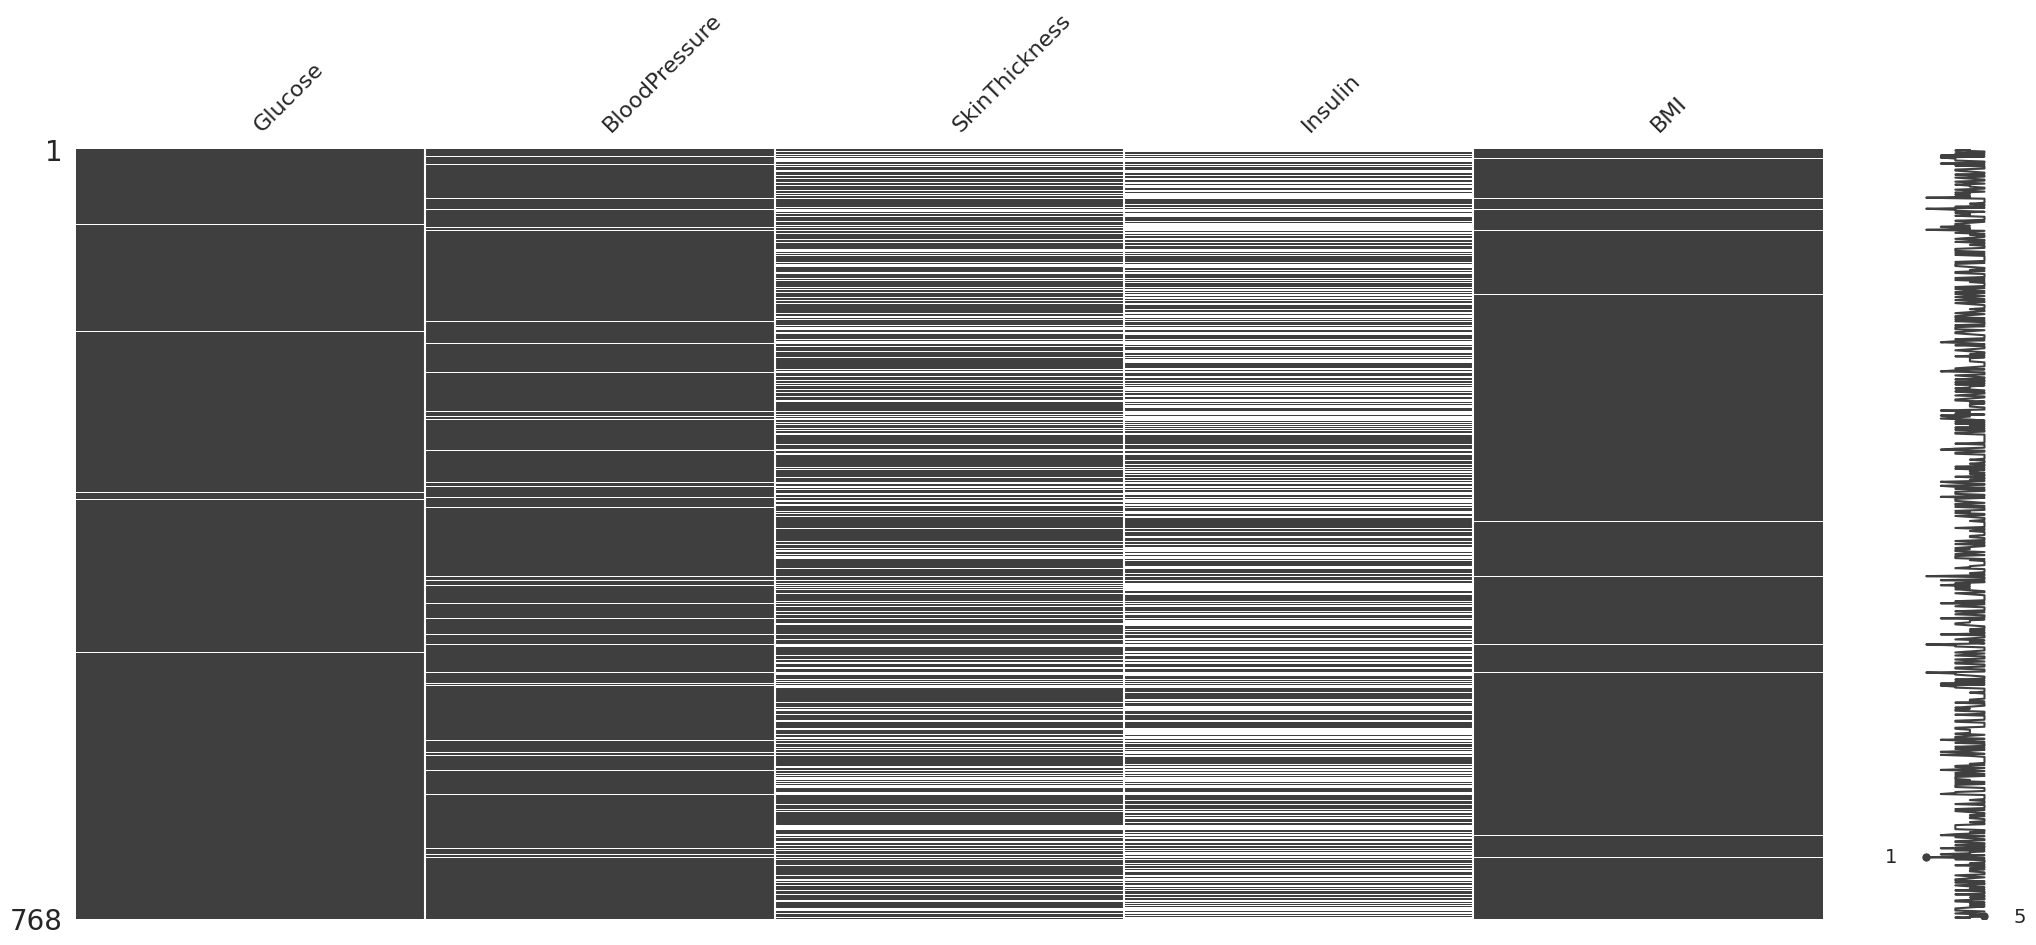

In [ ]:
msno.matrix(df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']])

# **Xử lý: Glucose, BloodPressure, BMI**

In [ ]:
#Thay thế các giá trị null bằng giá trị trung bình của cột đó:

df['Glucose'].fillna(df['Glucose'].median(), inplace =True)

df['BloodPressure'].fillna(df['BloodPressure'].median(), inplace =True)

df['BMI'].fillna(df['BMI'].median(), inplace =True)

# **Xử lý: Insulin dựa trên Glucose**

In [ ]:
by_Glucose_Age_Insulin_Grp = df.groupby(['Glucose'])

def fill_Insulin(series):
    return series.fillna(series.median())
df['Insulin'] = by_Glucose_Age_Insulin_Grp['Insulin'].transform(fill_Insulin)

In [ ]:
df['Insulin'] = df['Insulin'].fillna(df['Insulin'].mean())

# **Xử lý: Skinthickness theo BMI**

In [ ]:
by_BMI_Insulin = df.groupby(['BMI'])

def fill_Skinthickness(series):
    return series.fillna(series.mean())
df['SkinThickness'] = by_BMI_Insulin['SkinThickness'].transform(fill_Skinthickness)

In [ ]:
df['SkinThickness'].fillna(df['SkinThickness'].mean(),inplace= True)

In [ ]:
df.isnull().sum()

Pregnancies      0
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
DPF              0
Age              0
Outcome          0
dtype: int64

**Nhận xét:** Skin thickness và BMI không có liên quan trực tiếp với nhau. Tuy nhiên, cả hai có thể bị ảnh hưởng bởi cùng một yếu tố chung, đó là mức độ mỡ trong cơ thể. Mức độ mỡ trong cơ thể lại liên quan đến bệnh tiểu đường.


# **PHÂN TÍCH DỮ LIỆU KHÁM PHÁ**

---


# **Phân tích đơn biến**

---




# 1.  Số lượng biến mục tiêu


array([<Axes: ylabel='Outcome'>], dtype=object)

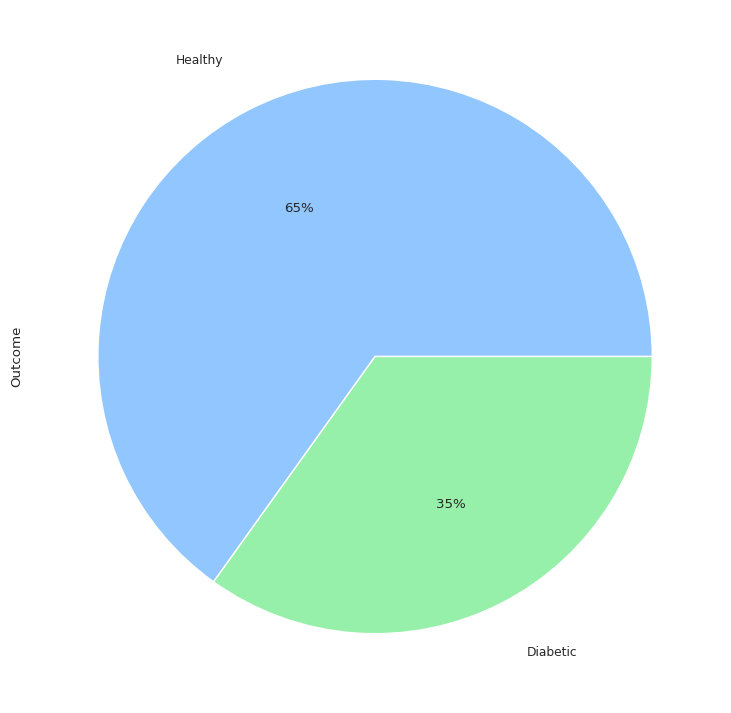

In [ ]:
import matplotlib.style as style
style.available

style.use('seaborn-pastel')
labels = ["Healthy", "Diabetic"]
df['Outcome'].value_counts().plot(kind='pie',labels=labels, subplots=True,autopct='%1.0f%%', labeldistance=1.2, figsize=(9,9))

Samples of diabetic people:  268
Samples of healthy people:  500


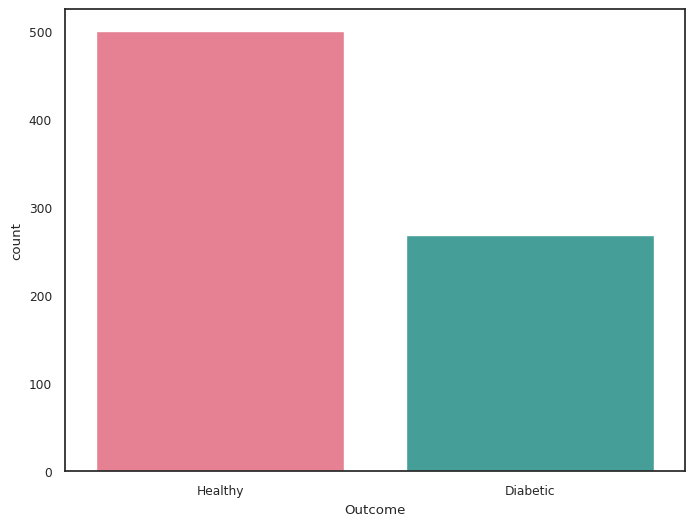

In [ ]:
from matplotlib.pyplot import figure, show

figure(figsize=(8,6))
ax = sns.countplot(x=df['Outcome'], data=df,palette="husl")
ax.set_xticklabels(["Healthy","Diabetic"])
healthy, diabetics = df['Outcome'].value_counts().values
print("Samples of diabetic people: ", diabetics)
print("Samples of healthy people: ", healthy)

Số lượng người mắc bệnh thấp hơn số lượng người không mắc bệnh khi khảo sát dự đoán bệnh nhân có mắc bệnh tiểu đường hay không





# 2.  Biểu đồ hộp (Box Plot)



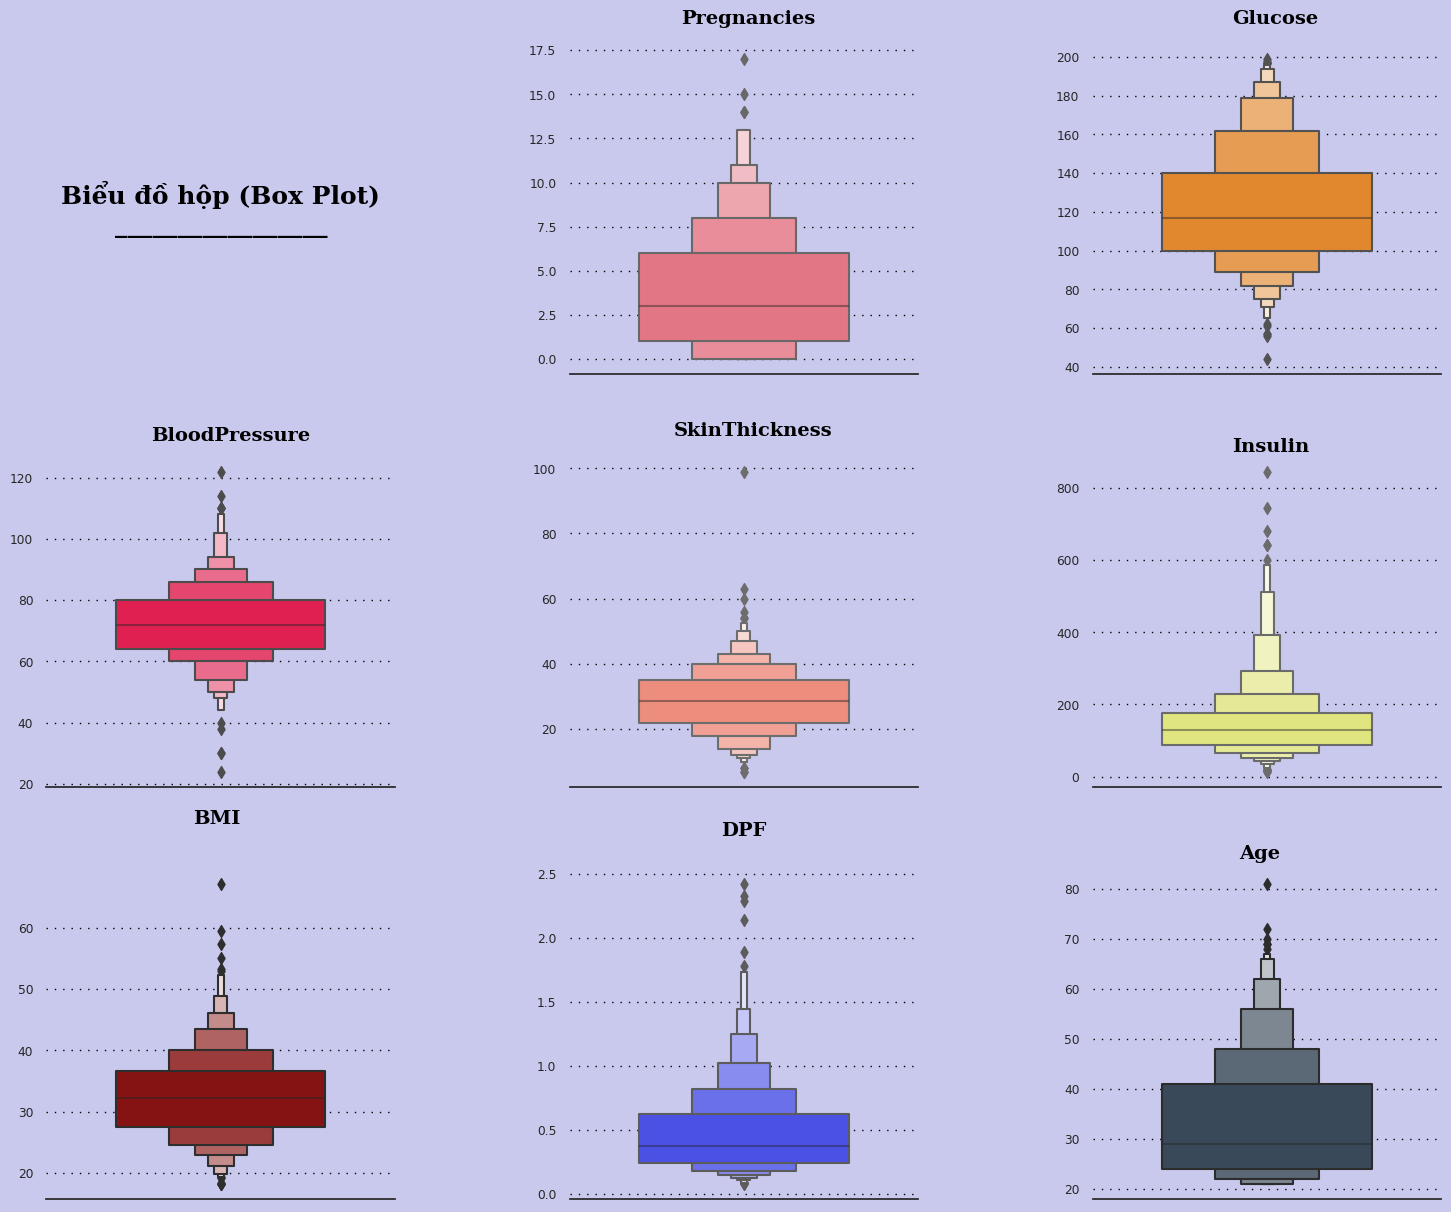

In [ ]:
fig = plt.figure(figsize=(18,15))
gs = fig.add_gridspec(3,3)
gs.update(wspace=0.5, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])
ax6 = fig.add_subplot(gs[2,0])
ax7 = fig.add_subplot(gs[2,1])
ax8 = fig.add_subplot(gs[2,2])

background_color = "#c9c9ee"
# c9c9ee
color_palette = ["#f56476","#ff8811","#ff0040","#ff7f6c","#f0f66e","#990000"]
fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color)
ax3.set_facecolor(background_color)
ax4.set_facecolor(background_color)
ax5.set_facecolor(background_color)
ax6.set_facecolor(background_color)
ax7.set_facecolor(background_color)
ax8.set_facecolor(background_color)


# Title of the plot
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,
         'Biểu đồ hộp (Box Plot)\n_________________',
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=18, fontweight='bold',
         fontfamily='serif',
         color="#000000")

# Pregnancies
ax1.text(-0.18, 19, 'Pregnancies', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax1,y=df['Pregnancies'],palette=["#f56476"],width=0.6)
ax1.set_xlabel("")
ax1.set_ylabel("")

# Glucose
ax2.text(-0.1, 217, 'Glucose', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax2.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax2,y=df['Glucose'],palette=["#ff8811"],width=0.6)
ax2.set_xlabel("")
ax2.set_ylabel("")

# BloodPressure
ax3.text(-0.20, 132, 'BloodPressure', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax3,y=df['BloodPressure'],palette=["#ff0040"],width=0.6)
ax3.set_xlabel("")
ax3.set_ylabel("")

# SkinThickness
ax4.text(-.2, 110, 'SkinThickness', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax4.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax4,y=df['SkinThickness'],palette=["#ff7f6c"],width=0.6)
ax4.set_xlabel("")
ax4.set_ylabel("")

# Insulin
ax5.text(-0.10, 900, 'Insulin', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax5,y=df['Insulin'],palette=["#f0f66e"],width=0.6)
ax5.set_xlabel("")
ax5.set_ylabel("")

# BMI
ax6.text(-0.08, 77, 'BMI', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax6.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax6,y=df['BMI'],palette=["#990000"],width=0.6)
ax6.set_xlabel("")
ax6.set_ylabel("")

# DPF
ax7.text(-0.065, 2.8, 'DPF', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax7.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax7,y=df['DPF'],palette=["#3339FF"],width=0.6)
ax7.set_xlabel("")
ax7.set_ylabel("")

# Age
ax8.text(-0.08, 86, 'Age', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax8.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax8,y=df['Age'],palette=["#34495E"],width=0.6)
ax8.set_xlabel("")
ax8.set_ylabel("")


for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    ax3.spines[s].set_visible(False)
    ax4.spines[s].set_visible(False)
    ax5.spines[s].set_visible(False)
    ax6.spines[s].set_visible(False)
    ax7.spines[s].set_visible(False)
    ax8.spines[s].set_visible(False)



# 3. Biểu đồ tính năng



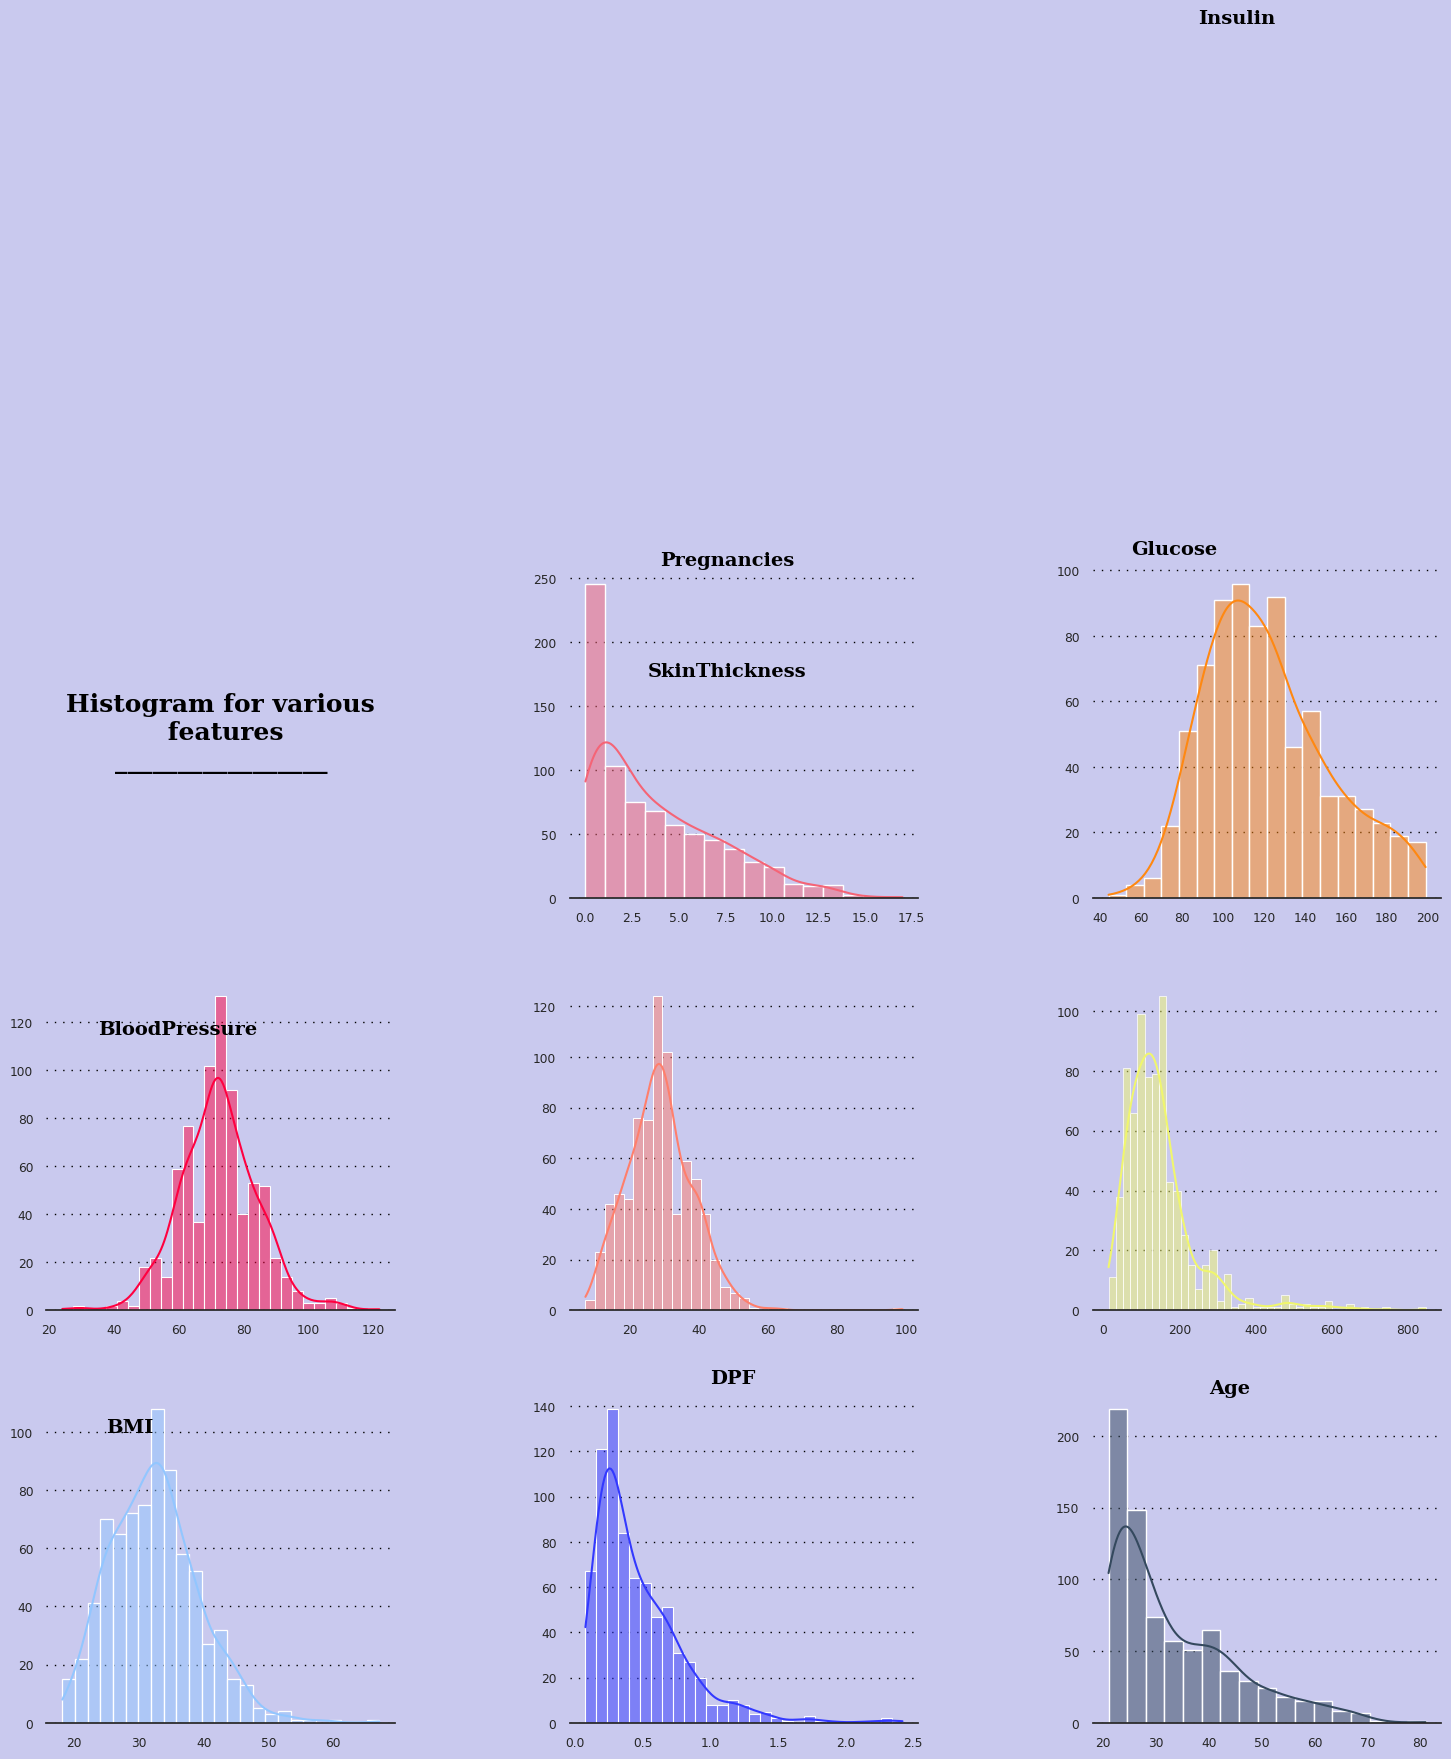

In [ ]:
fig = plt.figure(figsize=(18,15))
gs = fig.add_gridspec(3,3)
gs.update(wspace=0.5, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])
ax6 = fig.add_subplot(gs[2,0])
ax7 = fig.add_subplot(gs[2,1])
ax8 = fig.add_subplot(gs[2,2])

background_color = "#c9c9ee"
# c9c9ee
color_palette = ["#f56476","#ff8811","#ff0040","#ff7f6c","#f0f66e","#990000"]
fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color)
ax3.set_facecolor(background_color)
ax4.set_facecolor(background_color)
ax5.set_facecolor(background_color)
ax6.set_facecolor(background_color)
ax7.set_facecolor(background_color)
ax8.set_facecolor(background_color)

# Title of the plot
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,
         'Histogram for various\n features\n_________________',
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=18, fontweight='bold',
         fontfamily='serif',
         color="#000000")

# Pregnancies
ax1.text(4, 260, 'Pregnancies', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.histplot(ax=ax1,x=df['Pregnancies'],color="#f56476",kde=True)
ax1.set_xlabel("")
ax1.set_ylabel("")

# Glucose
ax2.text(55, 105, 'Glucose', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax2.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.histplot(ax=ax2,x=df['Glucose'],color="#ff8811",kde=True)
ax2.set_xlabel("")
ax2.set_ylabel("")

# BloodPressure
ax3.text(35, 115, 'BloodPressure', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.histplot(ax=ax3,x=df['BloodPressure'],color="#ff0040",kde=True)
ax3.set_xlabel("")
ax3.set_ylabel("")

# SkinThickness
ax4.text(25, 250, 'SkinThickness', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax4.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.histplot(ax=ax4,x=df['SkinThickness'],color="#ff7f6c",kde=True)
ax4.set_xlabel("")
ax4.set_ylabel("")

# Insulin
ax5.text(250, 430, 'Insulin', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.histplot(ax=ax5,x=df['Insulin'],color="#f0f66e",kde=True)
ax5.set_xlabel("")
ax5.set_ylabel("")

# BMI
ax6.text(25, 100, 'BMI', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax6.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.histplot(ax=ax6,x=df['BMI'],palette=["#990000"],kde=True)
ax6.set_xlabel("")
ax6.set_ylabel("")

# DPF
ax7.text(1, 150, 'DPF', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax7.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.histplot(ax=ax7,x=df['DPF'],color="#3339FF",kde=True)
ax7.set_xlabel("")
ax7.set_ylabel("")

# Age
ax8.text(40, 230, 'Age', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax8.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.histplot(ax=ax8,x=df['Age'],color="#34495E",kde=True)
ax8.set_xlabel("")
ax8.set_ylabel("")


for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    ax3.spines[s].set_visible(False)
    ax4.spines[s].set_visible(False)
    ax5.spines[s].set_visible(False)
    ax6.spines[s].set_visible(False)
    ax7.spines[s].set_visible(False)
    ax8.spines[s].set_visible(False)

**Nhận xét các chỉ số về người ít có khả năng bị bệnh tiểu đường**

Pregnancies (Số lần mang thai): Người mà mang thai từ 0-6 lần

>> Nhận xét: Số lần mang thai có thể ảnh hưởng đến sức khỏe của phụ nữ, và nghiên cứu đã chỉ ra rằng người mang thai nhiều lần có nguy cơ bị bệnh tiểu đường tăng.

Glucose (Đường huyết): Người có lượng đường huyết từ 100- 150 mg/dl

>> Nhận xét: Mức đường huyết trong khoảng này thường được coi là bình thường, và người có mức đường huyết ổn định ít khả năng phát triển bệnh tiểu đường.

BloodPressure (Huyết áp): Người có chỉ số huyết áp từ 70-80

>> Nhận xét: Huyết áp ổn định thường là một dấu hiệu tích cực, và người có huyết áp ổn định ít khả năng phát triển bệnh tiểu đường.

SkinThickness:Người có chỉ số SkinThickness từ 0-30

>> Nhận xét: Chỉ số SkinThickness có thể liên quan đến mức mỡ dưới da, và người có chỉ số thấp hơn có thể ít khả năng phát triển bệnh tiểu đường.

Insulin (Insulin):Người có chỉ số Insulin từ 0-200

>> Nhận xét: Mức Insulin bình thường thường liên quan đến sự cân bằng insulin trong cơ thể, và người có mức độ này ít khả năng gặp vấn đề về đường huyết.

BMI (Chỉ số Khối cơ thể): Người có chỉ số BMI từ 25-35

>> Nhận xét: BMI trong khoảng này thường được coi là khoảng bình thường hoặc hơi thừa cân, và người có BMI trong khoảng này ít khả năng phát triển bệnh tiểu đường.

DPF (Chỉ số dòng họ tiểu đường): Người có chỉ số dòng họ tiểu đường từ 0.25-0.5

>> Nhận xét: Chỉ số DPF thường được sử dụng để đánh giá yếu tố di truyền, và người có chỉ số này trong khoảng ổn định thì ít khả năng bị ảnh hưởng bởi yếu tố di truyền.

Age (Tuổi): Người có tuổi từ 25- 45

>> Nhận xét:Tuổi có thể ảnh hưởng đến rủi ro bệnh tiểu đường, và người trẻ hơn thường ít khả năng phát triển bệnh







# **Phân tích hai biến**

---





# **1. Ma trận tương quan của các tính năng**

In [ ]:
df_corr = df.corr().transpose()
df_corr

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
Pregnancies,1.000000,0.128213,0.208615,0.064381,0.046741,0.021559,-0.033523,0.544341,0.221898
Glucose,0.128213,1.000000,0.218937,0.188996,0.566640,0.231049,0.137327,0.266909,0.492782
BloodPressure,0.208615,0.218937,1.000000,0.183123,0.125499,0.281257,-0.002378,0.324915,0.165723
SkinThickness,0.064381,0.188996,0.183123,1.000000,0.210167,0.636708,0.128380,0.108672,0.232150
Insulin,0.046741,0.566640,0.125499,0.210167,1.000000,0.198895,0.114325,0.185146,0.279690
BMI,0.021559,0.231049,0.281257,0.636708,0.198895,1.000000,0.153438,0.025597,0.312038
DPF,-0.033523,0.137327,-0.002378,0.128380,0.114325,0.153438,1.000000,0.033561,0.173844
Age,0.544341,0.266909,0.324915,0.108672,0.185146,0.025597,0.033561,1.000000,0.238356
Outcome,0.221898,0.492782,0.165723,0.232150,0.279690,0.312038,0.173844,0.238356,1.000000


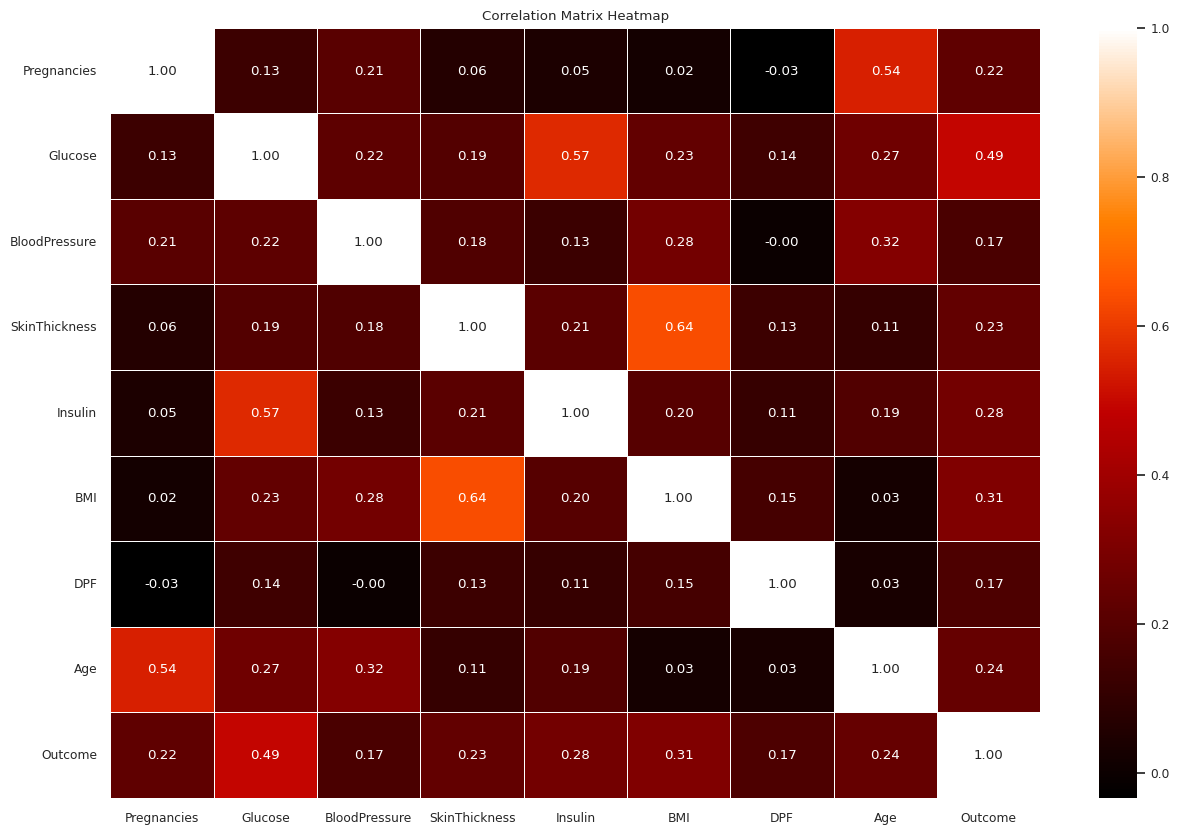

In [ ]:
#Graph I.
correlation_matrix = df.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='gist_heat', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()


Mối tương quan giữa các biến đặc trưng trong tập dữ liệu là thấp, không có cặp biến nào có mối tương quan cao. Để hiểu rõ hơn về ảnh hưởng của từng biến đặc trưng đối với mục tiêu ('Outcome'), cần tiến hành phân tích mối tương tác giữa mỗi biến và mục tiêu.

Ngoài ra, mối tương quan trung bình giữa 'Tuổi' và 'Mang thai' chỉ làm rõ thêm ý tưởng thông thường rằng phụ nữ có xu hướng có cơ hội mang thai cao hơn khi tuổi tăng lên.


---



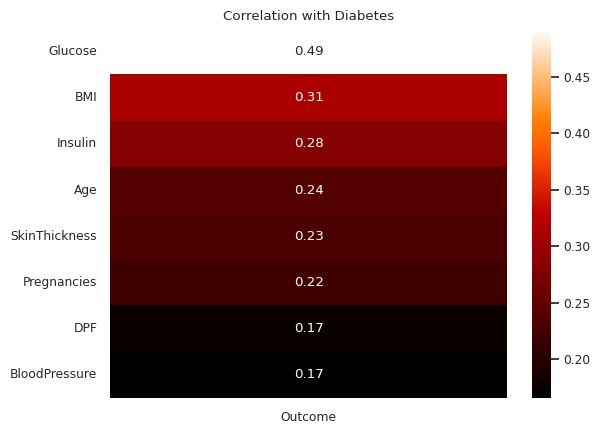

In [ ]:
corr = df.corr()
target_corr = corr['Outcome'].drop('Outcome')

# Sắp xếp các giá trị tương quan theo thứ tự giảm dần
target_corr_sorted = target_corr.sort_values(ascending=False)

# Tạo bản đồ nhiệt về các mối tương quan với cột mục tiêu
sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="gist_heat", annot=True, fmt='.2f')
plt.title('Correlation with Diabetes')
plt.show()

**Nhìn vào kết quả tương quan, chúng ta có thể thấy rằng các Đặc điểm khác nhau có mức độ tương quan khác nhau với kết quả (bệnh tiểu đường).**

- Glucose: Với hệ số tương quan là 0,47, đây là đặc điểm có mối tương quan chặt chẽ nhất với kết quả. Điều này cho thấy mức glucose cao hơn có thể là một dấu hiệu quan trọng của bệnh tiểu đường.
- BMI: Đặc điểm này có mối tương quan 0,29 với kết quả. Mặc dù không mạnh bằng glucose nhưng đây vẫn là mối tương quan vừa phải, cho thấy chỉ số khối cơ thể cũng có thể là một yếu tố quan trọng trong bệnh tiểu đường.
- Age: Tuổi có mối tương quan 0,24 với kết quả. Điều này cho thấy những người lớn tuổi có nhiều khả năng mắc bệnh tiểu đường hơn.
- Pregnancies: Đặc điểm này có mối tương quan 0,22 với kết quả. Điều này có thể gợi ý rằng mang thai nhiều hơn có thể làm tăng nguy cơ mắc bệnh tiểu đường.
- DPF: Với hệ số tương quan là 0,17, đặc điểm này có mối tương quan nhẹ với kết quả. Điều này cho thấy ảnh hưởng di truyền có thể đóng một vai trò trong bệnh tiểu đường.
- Insulin: Tính năng này có mối tương quan 0,13 với kết quả. Đây là mối tương quan tương đối yếu, cho thấy rằng chỉ riêng mức insulin có thể không phải là yếu tố dự báo mạnh mẽ về bệnh tiểu đường.
- Skin Thickness: Với hệ số tương quan là 0,07, đặc điểm này có mối tương quan rất yếu với kết quả. Điều này cho thấy độ dày của da có thể không phải là yếu tố quan trọng gây ra bệnh tiểu đường.
- Blood Pressure: Tính năng này có mối tương quan yếu nhất là 0,07 với kết quả. Điều này cho thấy huyết áp có thể không phải là yếu tố quan trọng gây ra bệnh tiểu đường.


# **Biểu đồ phân bố**

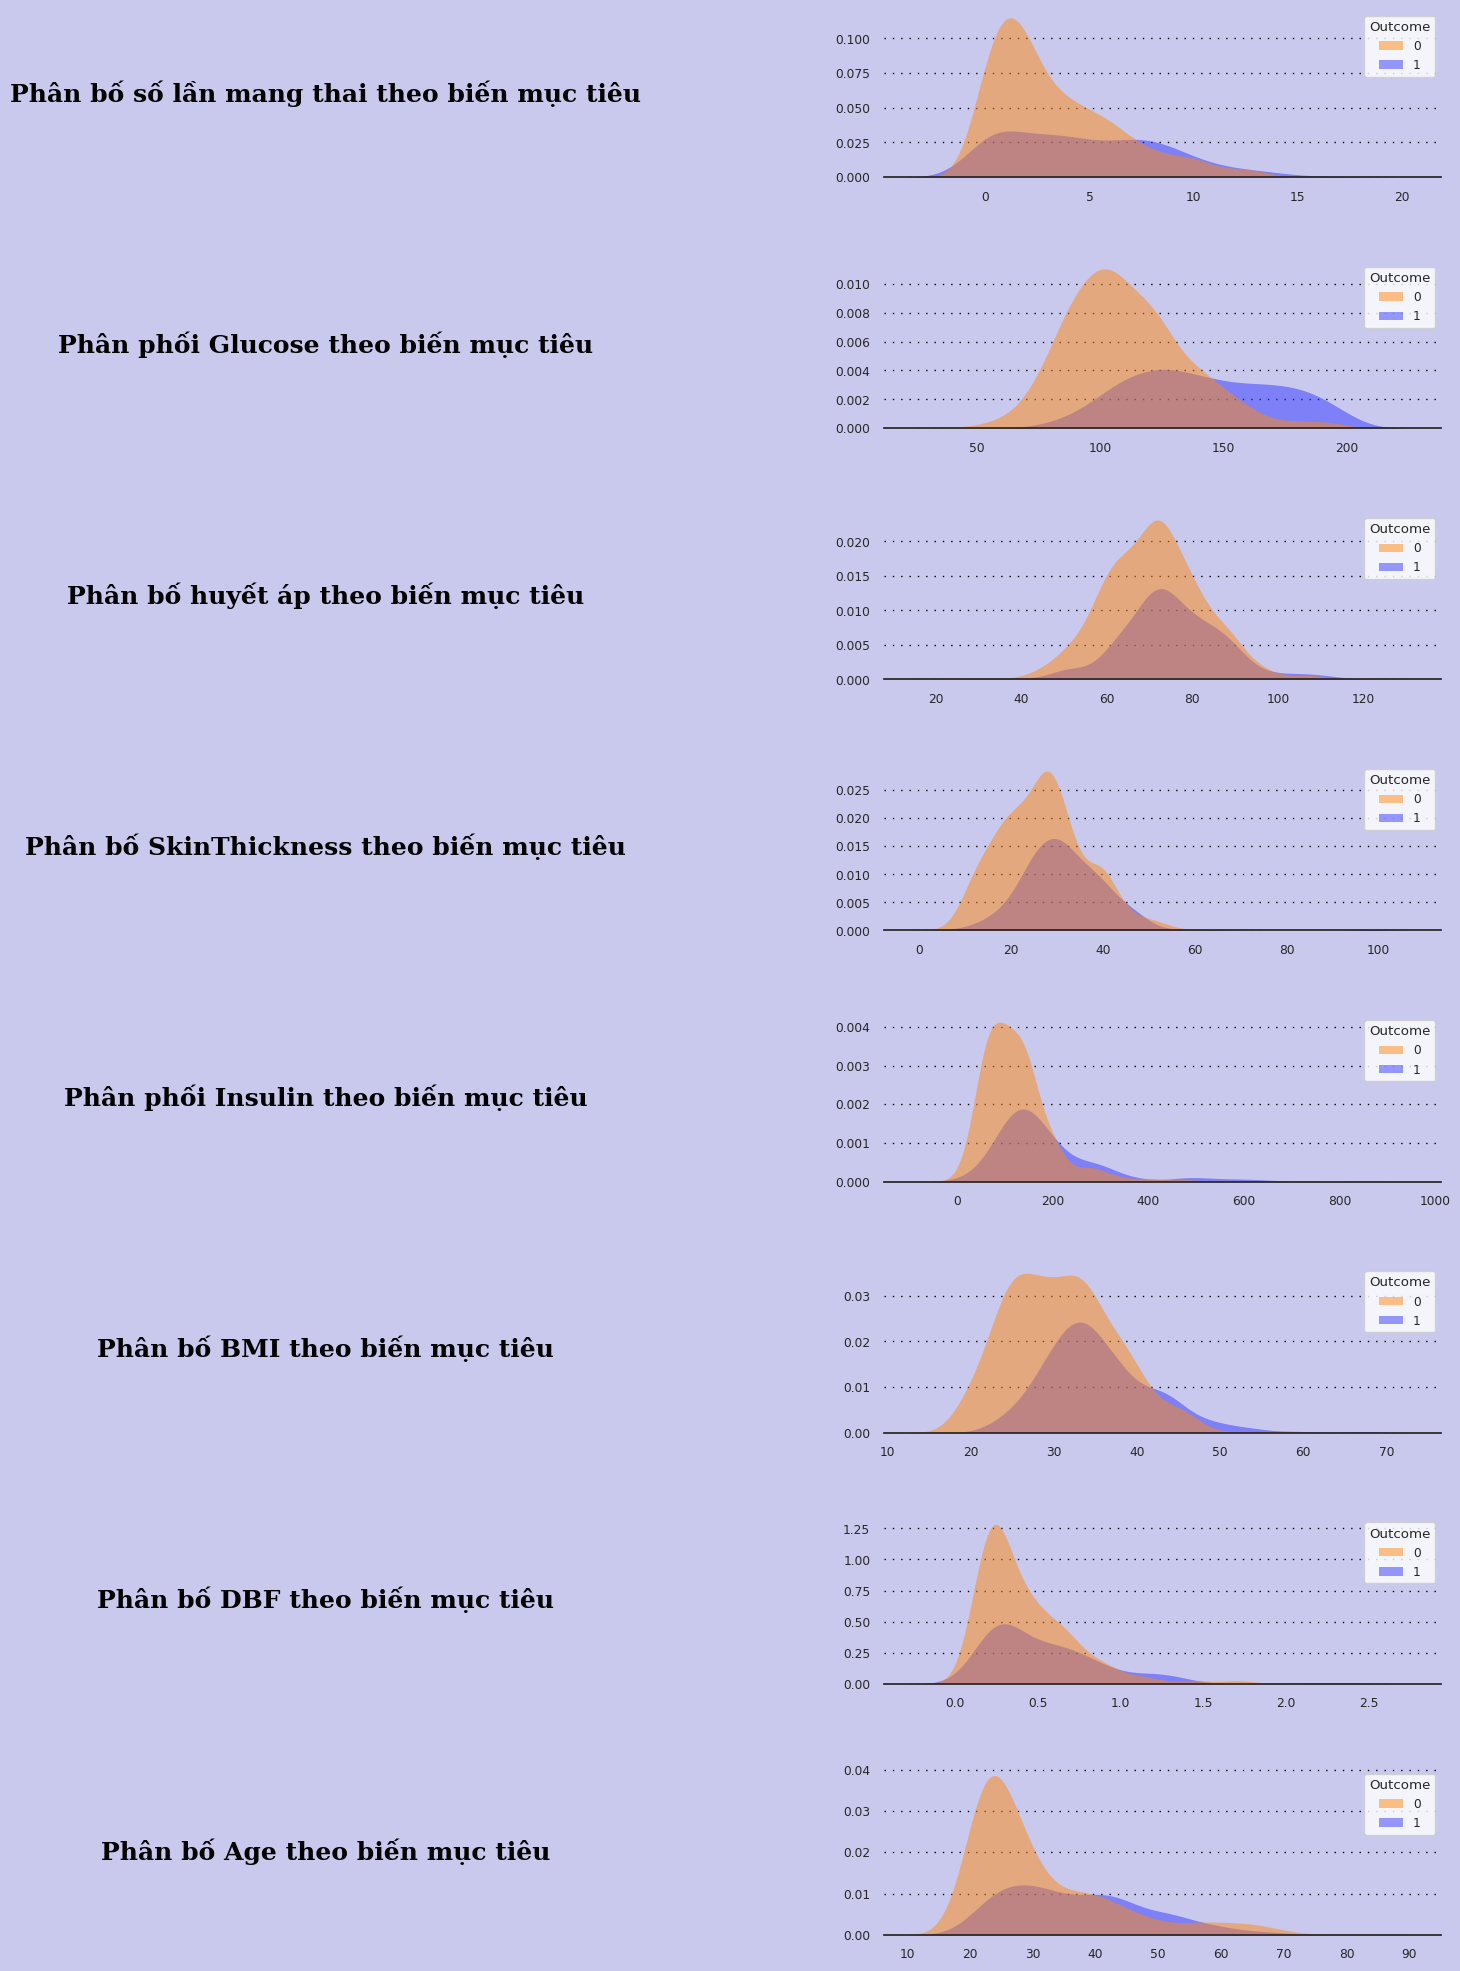

In [ ]:
fig = plt.figure(figsize=(18,25))
gs = fig.add_gridspec(8,2)
gs.update(wspace=0.5, hspace=0.5)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])
ax4 = fig.add_subplot(gs[2,0])
ax5 = fig.add_subplot(gs[2,1])
ax6 = fig.add_subplot(gs[3,0])
ax7 = fig.add_subplot(gs[3,1])
ax8 = fig.add_subplot(gs[4,0])
ax9 = fig.add_subplot(gs[4,1])
ax10 = fig.add_subplot(gs[5,0])
ax11 = fig.add_subplot(gs[5,1])
ax12 = fig.add_subplot(gs[6,0])
ax13 = fig.add_subplot(gs[6,1])
ax14 = fig.add_subplot(gs[7,0])
ax15 = fig.add_subplot(gs[7,1])

background_color = "#c9c9ee"
color_palette = ["#f56476","#ff8811","#ff0040","#ff7f6c","#f0f66e","#990000"]
fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color)
ax3.set_facecolor(background_color)
ax4.set_facecolor(background_color)
ax5.set_facecolor(background_color)
ax6.set_facecolor(background_color)
ax7.set_facecolor(background_color)
ax8.set_facecolor(background_color)
ax9.set_facecolor(background_color)
ax10.set_facecolor(background_color)
ax11.set_facecolor(background_color)
ax12.set_facecolor(background_color)
ax13.set_facecolor(background_color)
ax14.set_facecolor(background_color)
ax15.set_facecolor(background_color)

# Pregnancies title
ax0.text(0.5,0.5,"Phân bố số lần mang thai theo biến mục tiêu",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax0.spines["bottom"].set_visible(False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.tick_params(left=False, bottom=False)

# Pregnancies
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax1, data=df, x='Pregnancies',hue="Outcome", fill=True,palette=["#ff8811","#3339FF"], alpha=.5, linewidth=0)
ax1.set_xlabel("")
ax1.set_ylabel("")

# Glucose title
ax2.text(0.5,0.5,"Phân phối Glucose theo biến mục tiêu",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax2.spines["bottom"].set_visible(False)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.tick_params(left=False, bottom=False)

# Glucose
ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax3, data=df, x='Glucose',hue="Outcome", fill=True,palette=["#ff8811","#3339FF"], alpha=.5, linewidth=0)
ax3.set_xlabel("")
ax3.set_ylabel("")

# BloodPressure title
ax4.text(0.5,0.5,"Phân bố huyết áp theo biến mục tiêu",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax4.spines["bottom"].set_visible(False)
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.tick_params(left=False, bottom=False)

# BloodPressure
ax5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax5, data=df, x='BloodPressure',hue="Outcome", fill=True,palette=["#ff8811","#3339FF"], alpha=.5, linewidth=0)
ax5.set_xlabel("")
ax5.set_ylabel("")

# SkinThickness title
ax6.text(0.5,0.5,"Phân bố SkinThickness theo biến mục tiêu",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax6.spines["bottom"].set_visible(False)
ax6.set_xticklabels([])
ax6.set_yticklabels([])
ax6.tick_params(left=False, bottom=False)


# SkinThickness
ax7.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax7, data=df, x='SkinThickness',hue="Outcome", fill=True,palette=["#ff8811","#3339FF"], alpha=.5, linewidth=0)
ax7.set_xlabel("")
ax7.set_ylabel("")

# Insulin title
ax8.text(0.5,0.5,"Phân phối Insulin theo biến mục tiêu",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax8.spines["bottom"].set_visible(False)
ax8.set_xticklabels([])
ax8.set_yticklabels([])
ax8.tick_params(left=False, bottom=False)

# Insulin
ax9.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax9, data=df, x='Insulin',hue="Outcome", fill=True,palette=["#ff8811","#3339FF"], alpha=.5, linewidth=0)
ax9.set_xlabel("")
ax9.set_ylabel("")

# BMI title
ax10.text(0.5,0.5,"Phân bố BMI theo biến mục tiêu",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax10.spines["bottom"].set_visible(False)
ax10.set_xticklabels([])
ax10.set_yticklabels([])
ax10.tick_params(left=False, bottom=False)

# BMI
ax11.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax11, data=df, x='BMI',hue="Outcome", fill=True,palette=["#ff8811","#3339FF"], alpha=.5, linewidth=0)
ax11.set_xlabel("")
ax11.set_ylabel("")

# DPF title
ax12.text(0.5,0.5,"Phân bố DBF theo biến mục tiêu",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax12.spines["bottom"].set_visible(False)
ax12.set_xticklabels([])
ax12.set_yticklabels([])
ax12.tick_params(left=False, bottom=False)

# DPF
ax13.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax13, data=df, x='DPF',hue="Outcome", fill=True,palette=["#ff8811","#3339FF"], alpha=.5, linewidth=0)
ax13.set_xlabel("")
ax13.set_ylabel("")

# Age title
ax14.text(0.5,0.5,"Phân bố Age theo biến mục tiêu",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax14.spines["bottom"].set_visible(False)
ax14.set_xticklabels([])
ax14.set_yticklabels([])
ax14.tick_params(left=False, bottom=False)

# Age
ax15.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax15, data=df, x='Age',hue="Outcome", fill=True,palette=["#ff8811","#3339FF"], alpha=.5, linewidth=0)
ax15.set_xlabel("")
ax15.set_ylabel("")



for i in ["top","left","right"]:
    ax0.spines[i].set_visible(False)
    ax1.spines[i].set_visible(False)
    ax2.spines[i].set_visible(False)
    ax3.spines[i].set_visible(False)
    ax4.spines[i].set_visible(False)
    ax5.spines[i].set_visible(False)
    ax6.spines[i].set_visible(False)
    ax7.spines[i].set_visible(False)
    ax8.spines[i].set_visible(False)
    ax9.spines[i].set_visible(False)
    ax10.spines[i].set_visible(False)
    ax11.spines[i].set_visible(False)
    ax12.spines[i].set_visible(False)
    ax13.spines[i].set_visible(False)
    ax14.spines[i].set_visible(False)
    ax15.spines[i].set_visible(False)


# **Box_Plot**

In [ ]:
fig = make_subplots(rows=2, cols=4, subplot_titles=('<b>Outcome vs. Pregnancies</b>',
                                                    '<b>Outcome vs. Glucose</b>',
                                                    '<b>Outcome vs. Blood Pressure</b>',
                                                    '<b>Outcome vs. Skin Thickness</b>',
                                                    '<b>Outcome vs. Insulin</b>',
                                                    '<b>Outcome vs. BMI</b>',
                                                    '<b>Outcome vs. DPF</b>',
                                                    '<b>Outcome vs. Age</b>'
                                                   ))

fig.add_trace(go.Box(y=df['Pregnancies'], x=df['Outcome']), row=1, col=1)
fig.add_trace(go.Box(y=df['Glucose'], x=df['Outcome']), row=1, col=2)
fig.add_trace(go.Box(y=df['BloodPressure'], x=df['Outcome']), row=1, col=3)
fig.add_trace(go.Box(y=df['SkinThickness'], x=df['Outcome']), row=1, col=4)
fig.add_trace(go.Box(y=df['Insulin'], x=df['Outcome']), row=2, col=1)
fig.add_trace(go.Box(y=df['BMI'], x=df['Outcome']), row=2, col=2)
fig.add_trace(go.Box(y=df['DPF'], x=df['Outcome']), row=2, col=3)
fig.add_trace(go.Box(y=df['Age'], x=df['Outcome']), row=2, col=4)


# Cập nhật bố cục trực quan
fig.update_layout(
    showlegend=False,
    width=1000,
    height=400,
    autosize=False,
    template="plotly_white",
)

# cập nhật cỡ chữ theo trục
fig.update_coloraxes(colorbar_tickfont_size=10)
# Cập nhật phông chữ trong tiêu đề: Rõ ràng tiêu đề của ô phụ là chú thích (Kích thước phông chữ của ô phụ được mã hóa cứng thành 16pt · Số phát hành #985)
fig.update_annotations(font_size=12)
# Giảm độ mờ
fig.update_traces(opacity=0.75)

fig.show()

# **Pair-plot**

---



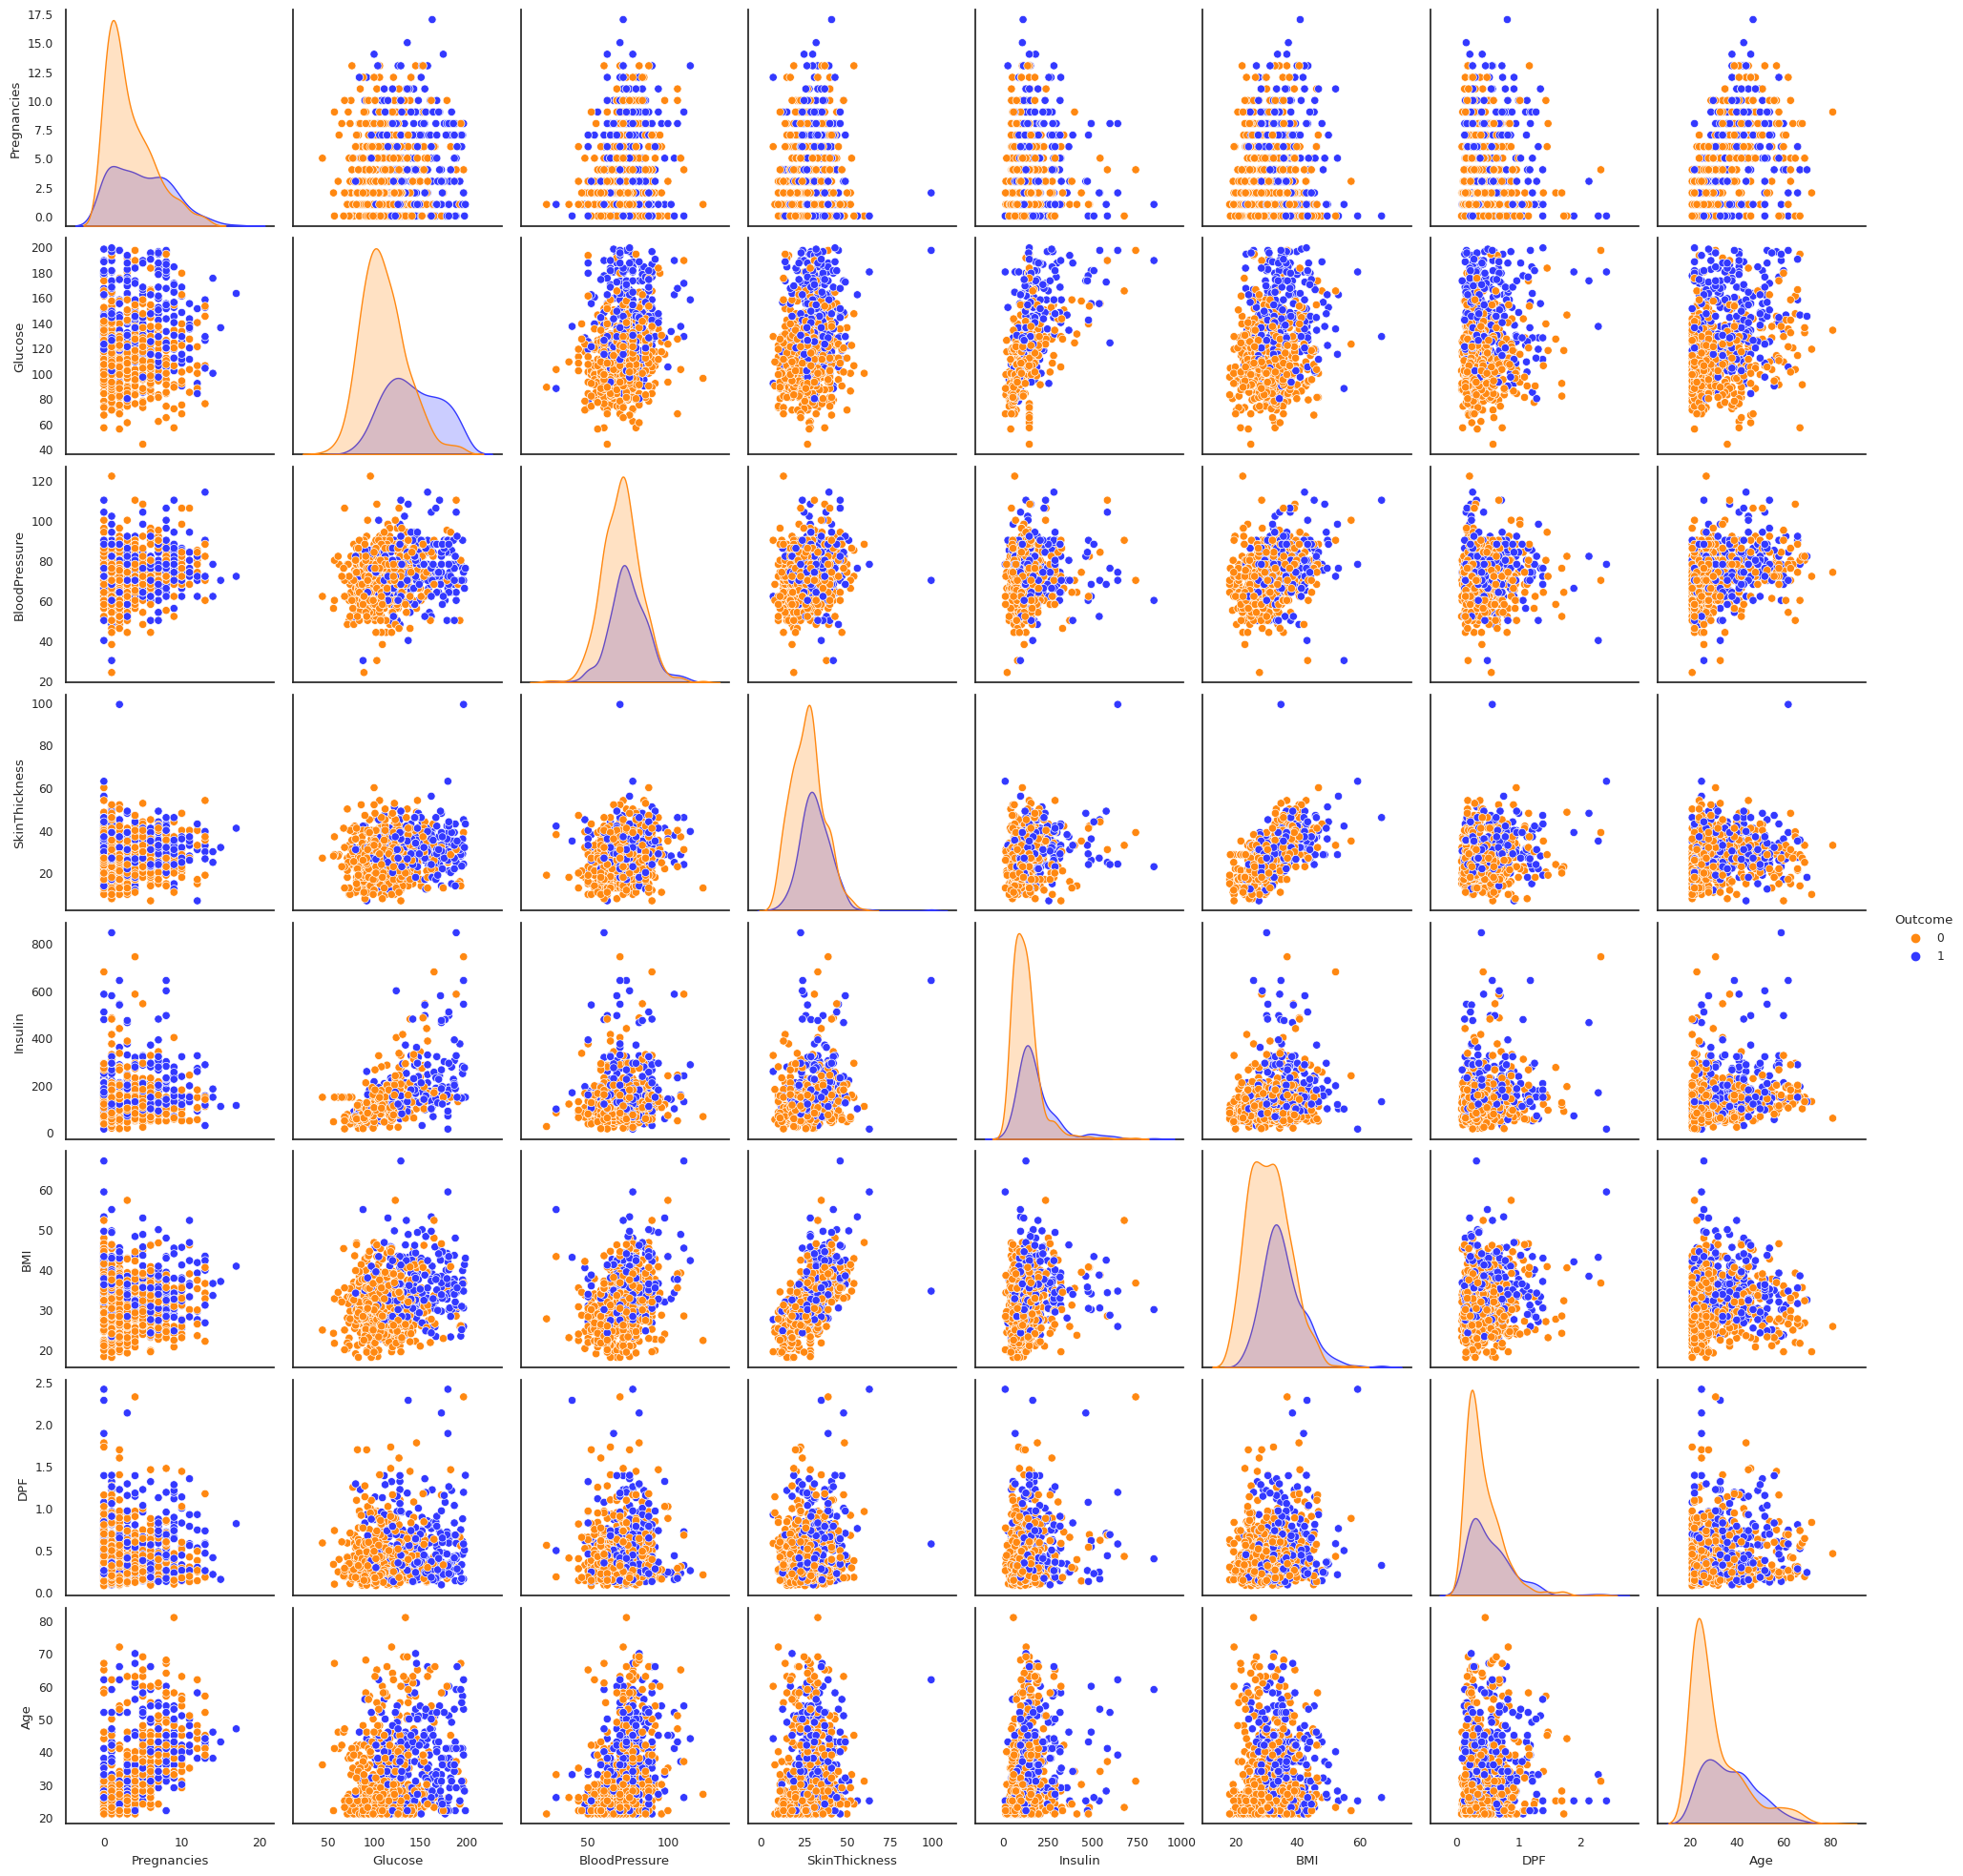

In [ ]:
sns.pairplot(df,hue='Outcome',palette = ["#ff8811","#3339FF"])
plt.show()

**Có thể thấy:**

Đặc điểm Glucose và BMI có sự phân bố gần bình thường
Các tính năng khác bị lệch nghiêm trọng về phía bên trái của bản phân phối
Các giá trị riêng biệt trong biểu đồ của các tính năng Glucose, BMI và Huyết áp cho biết các giá trị ngoại lệ trong dữ liệu cần được xử lý trong quy trình xử lý dữ liệu để chuẩn bị dữ liệu cho mô hình ML


# **Biểu đồ phân tán của BloodPressure với Glucose với Age wrt Kết quả**

---



In [ ]:
fig = px.scatter_3d(df, x='Age', y='Glucose', z='BloodPressure',
              color='Outcome',size_max=18,color_continuous_scale=["#3339FF", "#ff8811"])
fig.update_layout({"template":"plotly_dark"})
fig.show()

# **Biểu đồ phân tán của Glucose với Insulin với DPF wrt Kết quả**

---



In [ ]:
fig = px.scatter_3d(df, x='Glucose', y='Insulin', z='DPF',
              color='Outcome',size_max=18,color_continuous_scale=["#3339FF", "#ff8811"])
fig.update_layout({"template":"plotly_dark"})
fig.show()

# XỬ LÝ DỮ LIỆU

---





# 1. Loại bỏ các ngoại lệ



In [ ]:
print ("---HÌNH DÁNG TRƯỚC KHI LOẠI BỎ CÁC NGOẠI LỆ---")
print(f"Hình dạng của tập dữ liệu: {colored(df.shape, 'yellow')}")

df.drop(df[df["Pregnancies"] > 14].index,inplace=True)
df.drop(df[df["Glucose"] < 50].index,inplace=True)
df.drop(df[df["BloodPressure"] > 120].index,inplace=True)
df.drop(df[df["SkinThickness"] > 80].index,inplace=True)
df.drop(df[df["Insulin"] > 600].index,inplace=True)
df.drop(df[df["BMI"] > 55].index,inplace=True)
df.drop(df[df["DPF"] > 2].index,inplace=True)
df.drop(df[df["Age"] > 70].index,inplace=True)

print("")
print ("---HÌNH DẠNG SAU KHI LOẠI BỎ CÁC NGOẠI LỆ---")
print(f"Hình dạng của tập dữ liệu: {colored(df.shape, 'yellow')}")

---HÌNH DÁNG TRƯỚC KHI LOẠI BỎ CÁC NGOẠI LỆ---
Hình dạng của tập dữ liệu: (768, 9)

---HÌNH DẠNG SAU KHI LOẠI BỎ CÁC NGOẠI LỆ---
Hình dạng của tập dữ liệu: (752, 9)


# 2. Loại bỏ độ lệch

Kiểm tra sự phân phối Insulin


<Axes: xlabel='Insulin', ylabel='Density'>

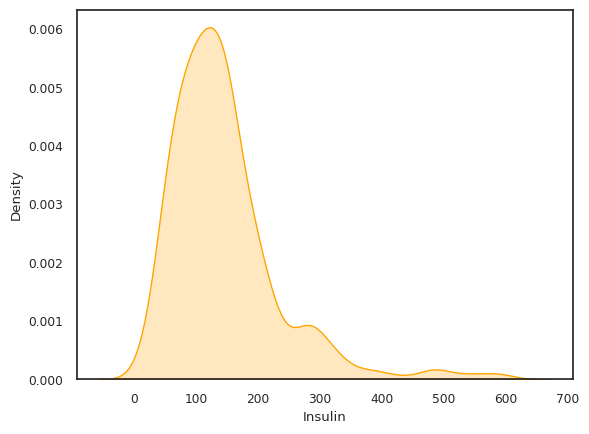

In [ ]:
print ("Kiểm tra sự phân phối Insulin")
sns.kdeplot(df['Insulin'],color='Orange',fill=True)

Loại bỏ độ lệch bằng hàm log và kiểm tra lại phân phối


<Axes: xlabel='Insulin', ylabel='Density'>

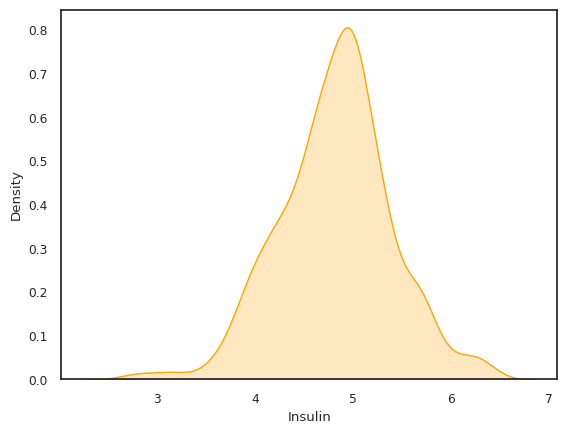

In [ ]:
print ("Loại bỏ độ lệch bằng hàm log và kiểm tra lại phân phối")
df['Insulin'] = df['Insulin'].map(lambda i : np.log(i) if i > 0 else 0)
sns.kdeplot(df['Insulin'],color='Orange',fill=True)

# 3. Mẫu tính năng đã sẵn sàng

In [ ]:
# nhập bộ chia tỷ lệ
from sklearn.preprocessing import StandardScaler

# tạo bản sao của khung dữ liệu
df1 = df
col_cols = list(df1.columns)

# xóa biến mục tiêu khỏi danh sách cột
col_cols.pop()

# tách biệt đặc điểm và mục tiêu
X = df1.drop(['Outcome'],axis=1)
y = df1[['Outcome']]

# khởi tạo bộ chia tỷ lệ
scaler = StandardScaler()
X[col_cols] = scaler.fit_transform(X[col_cols])
print("The first 5 rows of X are")
X.head()

The first 5 rows of X are


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age
0,0.652738,0.900609,-0.022757,0.715461,1.416074,0.193305,0.546800,1.467078
1,-0.853888,-1.207144,-0.528558,0.062640,-1.622397,-0.869417,-0.360223,-0.180588
2,1.255388,2.071583,-0.697158,0.020742,0.325059,-1.370415,0.694684,-0.093869
3,-0.853888,-1.073319,-0.528558,-0.590181,-0.480825,-0.641691,-0.964904,-1.047781
5,0.351413,-0.169996,0.145844,-1.025394,-0.286907,-1.021235,-0.853170,-0.267308


# MÔ HÌNH & SIÊU ĐIỀU CHỈNH

---



# Cài đặt gói

---



In [ ]:
!pip install scikit-optimize

In [ ]:

# Chia thử nghiệm tàu
from sklearn.model_selection import train_test_split

# Mô hình cơ sở
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Tập hợp và tăng cường
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

# số liệu
from sklearn.metrics import accuracy_score, classification_report, roc_curve

# Xác thực chéo
from sklearn.model_selection import cross_val_score

# Điều chỉnh siêu tham số
from functools import partial
from skopt import gp_minimize
from skopt import space
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# **Đào tạo và phân chia dữ liệu**

---



* Quá trình phân chia dữ liệu giúp đảm bảo rằng mô hình được huấn luyện trên một tập dữ liệu đa dạng và không được nhìn thấy trước, và sau đó được đánh giá trên một tập dữ liệu độc lập để đo lường hiệu suất và khả năng tổng quát hóa của mô hình.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size = 0.2, random_state = 42)
print(f"Hình dạng của X_train is      {colored(X_train.shape,'yellow')}")
print(f"Hình dạng của X_test is       {colored(X_test.shape,'yellow')}")
print(f"Hình dạng của y_train is      {colored(y_train.shape,'yellow')}")
print(f"Hình dạng của y_test is       {colored(y_test.shape,'yellow')}")

Hình dạng của X_train is      (601, 8)
Hình dạng của X_test is       (151, 8)
Hình dạng của y_train is      (601, 1)
Hình dạng của y_test is       (151, 1)


# **Huấn luyện dữ liệu với các mô hình cơ sở mà không cần điều chỉnh siêu tham số**

---



In [ ]:
models = [
    ('DecisionTreeClassifier', DecisionTreeClassifier()),
    ('RandomForestClassifier', RandomForestClassifier()),
    ('SVM_Linear', SVC(kernel='linear')),
    ('SVM_Polynomial', SVC(kernel='poly')),
    ('SVM_Gaussian', SVC(kernel='rbf')),
    ('LogisticRegression', LogisticRegression()),
    ('KNeighborsClassifier', KNeighborsClassifier()),
    ('AdaBoostClassifier', AdaBoostClassifier()),
    ('GradientBoostingClassifier', GradientBoostingClassifier())
]

print("Điểm chính xác của các mô hình là :")
for model_name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{colored(model_name,'blue')}")
    print(f"{colored(accuracy_score(y_test,y_pred), 'yellow')}\n")

Điểm chính xác của các mô hình là :
DecisionTreeClassifier
0.7284768211920529

RandomForestClassifier
0.8079470198675497

SVM_Linear
0.7814569536423841

SVM_Polynomial
0.7748344370860927

SVM_Gaussian
0.7615894039735099

LogisticRegression
0.7947019867549668

KNeighborsClassifier
0.7682119205298014

AdaBoostClassifier
0.7814569536423841

GradientBoostingClassifier
0.8013245033112583



* accuracy_score cho biết tỷ lệ phần trăm các dự đoán đúng trên tập dữ liệu
kiểm tra. Điều này giúp đánh giá xem mô hình có thể phân loại đúng bao nhiêu mẫu và có đáng tin cậy không.
* Accuracy_score có thể được sử dụng để đánh giá hiệu suất của mô hình với các giá trị siêu tham số khác nhau. Bằng cách thay đổi giá trị của các siêu tham số, ta có thể đánh giá xem liệu mô hình có cải thiện hay không. Tuy nhiên, cần lưu ý rằng accuracy_score không phản ánh đầy đủ hiệu suất của mô hình nếu dữ liệu không cân bằng hoặc tỉ lệ các lớp không đồng đều.

# **Điều chỉnh siêu tham số bằng GridSearchCV**

---



In [ ]:
# Xác định siêu tham số cho mỗi phân loại
param_grid_decision_tree = {'max_depth': [3, 5, 7, 10]}
param_grid_random_forest = {'n_estimators': [50, 100, 150], 'max_depth': [3, 5, 7]}
param_grid_svc_linear = {'C': [0.1, 1, 10]}
param_grid_svc_poly = {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
param_grid_svc_gaussian = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10]}
param_grid_logistic_regression = {'C': [0.1, 1, 10]}
param_grid_kneighbors = {'n_neighbors': [3, 5, 7]}
param_grid_adaboost = {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 1]}
param_grid_gradientboost = {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 1]}

# Tạo danh sách các bộ chứa tên model và lưới tham số tương ứng của chúng
models_params = [
    ('DecisionTreeClassifier', DecisionTreeClassifier(), param_grid_decision_tree),
    ('RandomForestClassifier', RandomForestClassifier(), param_grid_random_forest),
    ('SVM_Linear', SVC(kernel='linear'), param_grid_svc_linear),
    ('SVM_Polynomial', SVC(kernel='poly'), param_grid_svc_poly),
    ('SVM_Gaussian', SVC(kernel='rbf'), param_grid_svc_gaussian),
    ('LogisticRegression', LogisticRegression(), param_grid_logistic_regression),
    ('KNeighborsClassifier', KNeighborsClassifier(), param_grid_kneighbors),
    ('AdaBoostClassifier', AdaBoostClassifier(), param_grid_adaboost),
    ('GradientBoostingClassifier', GradientBoostingClassifier(), param_grid_gradientboost)
]

best_score = 0
best_model_name = ""

# Thực hiện GridSearchCV cho từng mô hình và in điểm
for name, model, param_grid in models_params:
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    score = grid_search.best_score_

    print(f"Best parameters for {name}:")
    print(grid_search.best_params_)
    print(f"Best score for {name}: {score}")

# Chọn điểm tốt nhất và mô hình tương ứng
    if score > best_score:
        best_score = score
        best_model_name = name

print(f"\nBest model: {best_model_name} with score: {best_score}")

Best parameters for DecisionTreeClassifier:
{'max_depth': 5}
Best score for DecisionTreeClassifier: 0.7154958677685951
Best parameters for RandomForestClassifier:
{'max_depth': 5, 'n_estimators': 50}
Best score for RandomForestClassifier: 0.7521487603305785
Best parameters for SVM_Linear:
{'C': 10}
Best score for SVM_Linear: 0.757107438016529
Best parameters for SVM_Polynomial:
{'C': 1, 'degree': 3}
Best score for SVM_Polynomial: 0.7321349862258953
Best parameters for SVM_Gaussian:
{'C': 1, 'gamma': 0.1}
Best score for SVM_Gaussian: 0.7454407713498623
Best parameters for LogisticRegression:
{'C': 1}
Best score for LogisticRegression: 0.7538429752066116
Best parameters for KNeighborsClassifier:
{'n_neighbors': 7}
Best score for KNeighborsClassifier: 0.7188016528925619
Best parameters for AdaBoostClassifier:
{'learning_rate': 0.1, 'n_estimators': 100}
Best score for AdaBoostClassifier: 0.7487741046831956
Best parameters for GradientBoostingClassifier:
{'learning_rate': 0.01, 'n_estimator

# **PHÂN CỤM BỆNH NHÂN TIỂU ĐƯỜNG**

# **Phân tích phân cụm**

Chuẩn hóa dữ liệu

Tiền xử lý là bước quan trọng trước khi huấn luyện mô hình. Ở đây, đặc điểm số được chuẩn hóa và đặc điểm phân loại được mã hóa. Chuẩn hóa không là bắt buộc, nhưng thường là thực hành tốt. StandardScaler trong sklearn giúp biến đổi dữ liệu sao cho giá trị trung bình là 0 và độ lệch chuẩn là 1.

In [ ]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df.drop('Outcome', axis=1))

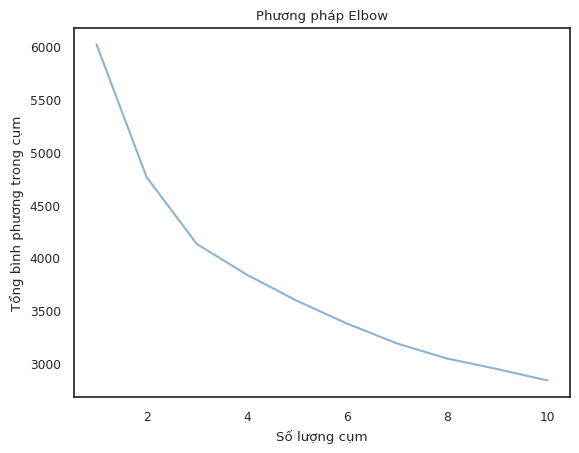

In [ ]:
# Xác định số cụm tối ưu bằng phương pháp Elbow
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Phương pháp Elbow')
plt.xlabel('Số lượng cụm')
plt.ylabel('Tổng bình phương trong cụm')
plt.show()


Biểu đồ Elbow là công cụ quan trọng để xác định số lượng cụm tối ưu trong phân cụm K-means. Trên biểu đồ, trục x thể hiện số lượng cụm, trong khi trục y biểu diễn Tổng bình phương trong cụm (WCSS) - một đánh giá về độ nhóm của dữ liệu.

'Elbow' trên biểu đồ là điểm mà thêm cụm không cải thiện đáng kể WCSS. Trong trường hợp này, có vẻ như có khoảng 4 cụm là số lượng tối ưu. Nhìn chung, số cụm tối ưu cho dữ liệu của bạn là 6, được xác định dựa trên phương pháp Elbow.


---




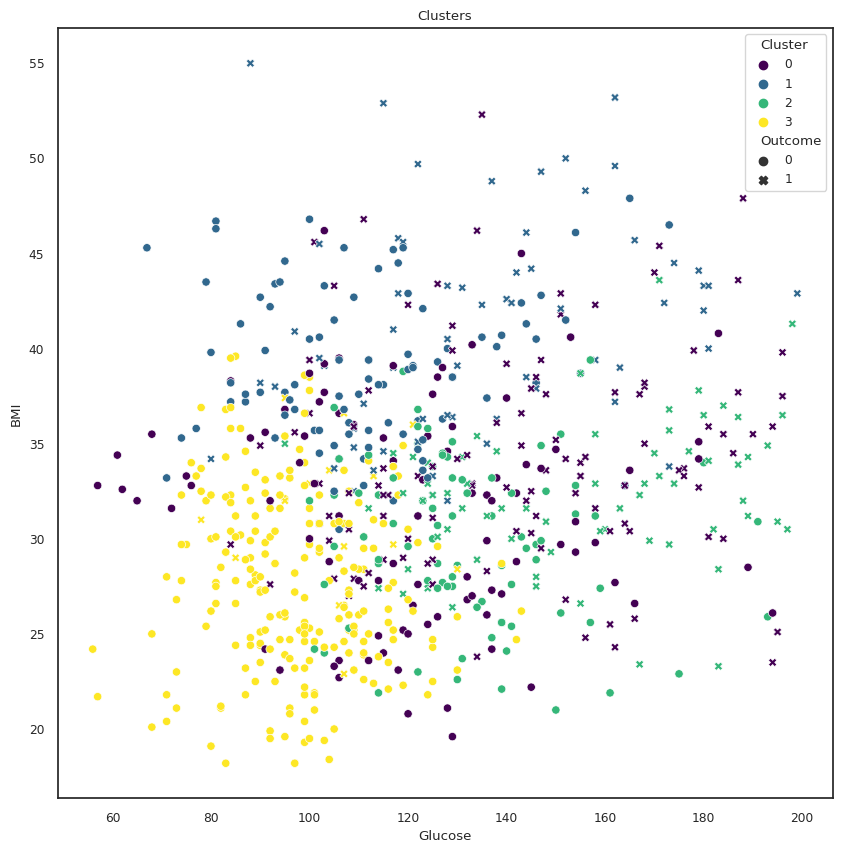

In [ ]:
# Phân cụm K-means phù hợp (** thay thế 'n_clusters' bằng số cụm mong muốn**)
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = kmeans.fit_predict(data_scaled)

# Thêm nhãn cụm vào dữ liệu gốc
df['Cluster'] = clusters

# Trực quan hóa các cụm bằng cách sử dụng 'Glucose' và 'BMI'
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='Glucose', y='BMI', hue='Cluster', style='Outcome', palette='viridis')
plt.title('Clusters')
plt.show()

Biểu đồ phân tán trực quan hóa mối quan hệ giữa Glucose và BMI, hai tính năng quan trọng trong tập dữ liệu của chúng em. Mỗi điểm trên biểu đồ đại diện cho một cá nhân trong tập dữ liệu và màu của điểm biểu thị cụm mà cá nhân đó thuộc về dựa trên phân tích phân cụm K-means:

Glucose: Tính năng này được thể hiện trên trục x. Có vẻ như các cá nhân có mức độ glucose khác nhau.
BMI: Tính năng này được thể hiện trên trục y. Tương tự như glucose, các cá nhân có nhiều giá trị BMI khác nhau.
Clusters: Các màu khác nhau trên biểu đồ đại diện cho các cụm khác nhau. Có vẻ như thuật toán phân cụm K-mean đã nhóm các cá nhân thành các cụm riêng biệt dựa trên Glucose và chỉ số BMI của họ.


# **Gom cụm**

In [ ]:
zero_features = ['Pregnancies','Glucose','BloodPressure','SkinThickness',"Insulin",'BMI']
total_count = df['Glucose'].count()

for feature in zero_features:
    zero_count = df[df[feature]==0][feature].count()
    print('{0} 0 number of cases {1}, percent is {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))
# Tiền xử lý dữ liệu
diabetes_mean = df[zero_features].mean()
df[zero_features]=df[zero_features].replace(0, diabetes_mean)

Pregnancies 0 number of cases 0, percent is 0.00 %
Glucose 0 number of cases 0, percent is 0.00 %
BloodPressure 0 number of cases 0, percent is 0.00 %
SkinThickness 0 number of cases 0, percent is 0.00 %
Insulin 0 number of cases 0, percent is 0.00 %
BMI 0 number of cases 0, percent is 0.00 %


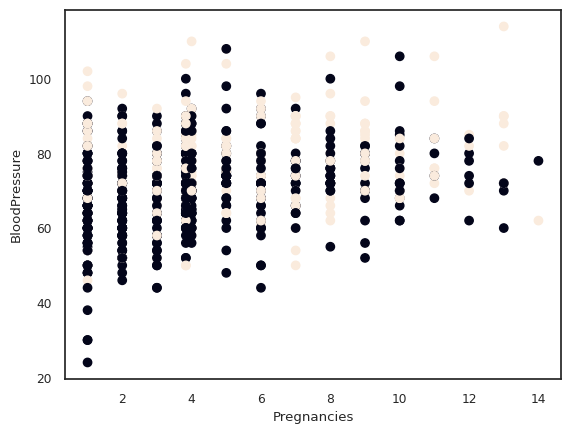

In [ ]:
import matplotlib.pyplot as plt
kmeans2 = KMeans(n_clusters=2, random_state=0).fit(df)
y_pred_2 = kmeans2.predict(df) #k=3

plt.xlabel('Pregnancies')
plt.ylabel('BloodPressure')

plt.scatter(df['Pregnancies'], df['BloodPressure'], c=y_pred_2)
plt.show()

Nhận xét: Có thể thấy huyết áp của phụ nữ người da đỏ sau khi mang thai đa số ở mức bình thường.

# **THUẬT TOÁN PHÂN LOẠI**

# **KNN**

Dự đoán được thực hiện dựa trên sự giống nhau của các quan sát với nhau. (Hãy cho tôi biết bạn bè của bạn, tôi sẽ cho bạn biết bạn là ai.)

K-Neighbors đơn vị quan sát gần nhất cho một đơn vị quan sát nhất định được tính toán. Biến phụ thuộc được dự đoán dựa trên k đơn vị quan sát gần nhất. Việc tính toán khoảng cách được thực hiện cho mỗi quan sát bằng cách sử dụng Euclide hoặc thước đo khoảng cách tương tự. Giá trị trung bình của biến phụ thuộc của k đơn vị quan sát gần nhất được lấy và gán cho quan sát chưa biết của chúng ta.

Nếu chúng ta định sử dụng KNN để phân loại, thay vì giá trị trung bình của k đơn vị quan sát gần nhất, chúng ta sẽ chọn lớp lặp lại thường xuyên nhất và gán nó cho biến đó.


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV

In [ ]:
## Tiền xử lý dữ liệu & Kỹ thuật tính năng

y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)
# Chúng tôi áp dụng StandardScaler, trả về một mảng có nhiều mảng
X_scaled = StandardScaler().fit_transform(X)
# Chuyển đổi nó trở lại DataFrame
X = pd.DataFrame(X_scaled, columns=X.columns)

In [ ]:
#Mô hình hóa và dự đoán

# Chúng tôi xây dựng mô hình của mình và điều chỉnh X, y cho nó
knn_model = KNeighborsClassifier().fit(X, y)
# Chúng tôi lấy mẫu ngẫu nhiên
random_user = X.sample(1, random_state=45)
# Chúng tôi đưa ra dự đoán
knn_model.predict(random_user)

array([0])

In [ ]:
#Đánh giá mô hình

# Đối với ma trận nhầm lẫn:
y_pred = knn_model.predict(X)
# Đối với AUC:
y_prob = knn_model.predict_proba(X)[:, 1]

print(classification_report(y, y_pred))
# acc 0.83
# f1 0.74
# AUC 0.90
roc_auc_score(y, y_prob)

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       493
           1       0.76      0.71      0.74       259

    accuracy                           0.83       752
   macro avg       0.81      0.80      0.80       752
weighted avg       0.82      0.83      0.82       752



0.9004283913006023

In [ ]:
# Chúng tôi thực hiện xác thực chéo 5 lần
cv_results = cross_validate(knn_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

print(cv_results['test_accuracy'].mean())
print(cv_results['test_f1'].mean())
print(cv_results['test_roc_auc'].mean())

# 0.73 Độ chính xác giảm
#0.59 Điểm F1 giảm
# 0,78 điểm AUC giảm

# Các bước có thể cải thiện:
# 1. Tăng cỡ mẫu.
#2. Tiền xử lý dữ liệu
# 3. Kỹ thuật tính năng
# 4. Tối ưu hóa thuật toán liên quan.

0.7287417218543046
0.5903149152757672
0.7702414376784124


In [ ]:
# Tối ưu hóa siêu tham số

# Kiểm tra thông số của nó
knn_model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
# Chúng ta cố gắng tìm số lượng hàng xóm tối ưu bằng cách thay đổi số lượng hàng xóm
knn_params = {"n_neighbors": range(2, 50)}

# Chúng tôi thực hiện tìm kiếm dạng lưới
knn_gs_best = GridSearchCV(knn_model,
                           knn_params,
                           cv=5,
                           n_jobs=-1,
                           verbose=1).fit(X, y)

# Có 48 ứng cử viên được xét xử và vì gấp 5 lần nên có tổng cộng 240 ca phẫu thuật phù hợp.
# Nó chỉ ra rằng số hàng xóm tốt nhất là 17.
knn_gs_best.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'n_neighbors': 44}

In [ ]:
# Mẫu cuối cùng

# Chúng tôi cập nhật mô hình của mình với các giá trị tốt nhất mà chúng tôi đã trích xuất
# Khi nó ở dạng từ điển dưới dạng khóa-giá trị, chúng tôi sẽ đánh giá nó 2 sao
knn_final = knn_model.set_params(**knn_gs_best.best_params_).fit(X, y)

# Chúng tôi sử dụng xác thực chéo để xem xét lỗi
cv_results = cross_validate(knn_final,
                            X,
                            y,
                            cv=5,
                            scoring=["accuracy", "f1", "roc_auc"])

print(cv_results['test_accuracy'].mean())
# Tăng từ 73 lên 76
print(cv_results['test_f1'].mean())
# Tăng từ 59 lên 61
print(cv_results['test_roc_auc'].mean())
# Tăng từ 78 lên 81

0.7713289183222958
0.6214539927636623
0.8313650401885695


# **Naive Bayes**

Naive Bayes là phương pháp phân loại áp dụng nguyên tắc độc lập có điều kiện của lớp với Định lý Bayes. Điều này có nghĩa là sự hiện diện của một đặc điểm không ảnh hưởng đến sự hiện diện của đặc điểm khác trong xác suất của một kết quả nhất định và mỗi yếu tố dự đoán đều có tác động như nhau đối với kết quả đó

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

param_grid_nb = {
    'var_smoothing': np.logspace(0,-2, num=100)
}
nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)

In [ ]:
best_model= nbModel_grid.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [ ]:
nb_pred=best_model.predict(X_test)

Báo cáo phân loại là:
               precision    recall  f1-score   support

           0       0.73      0.94      0.82        96
           1       0.80      0.41      0.55        58

    accuracy                           0.74       154
   macro avg       0.76      0.68      0.68       154
weighted avg       0.75      0.74      0.72       154


 F1:
 0.5454545454545454

 Điểm chính xác là:
 0.8

 Điểm thu hồi là:
 0.41379310344827586

 Confusion Matrix:



<Axes: >

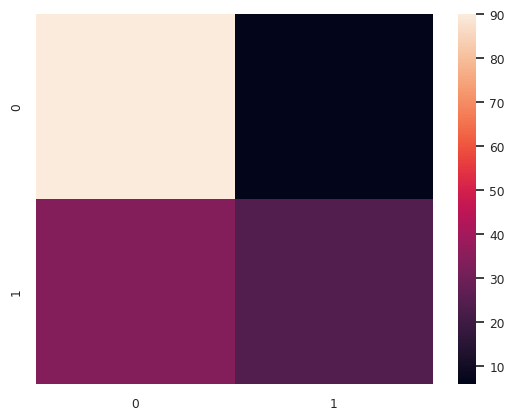

In [ ]:
print("Báo cáo phân loại là:\n",classification_report(y_test,nb_pred))
print("\n F1:\n",f1_score(y_test,nb_pred))
print("\n Điểm chính xác là:\n",precision_score(y_test,nb_pred))
print("\n Điểm thu hồi là:\n",recall_score(y_test,nb_pred))
print("\n Confusion Matrix:\n")
sns.heatmap(confusion_matrix(y_test,nb_pred))

# **Cây quyết định**


- Cây quyết định là một phương pháp được Leo Breiman đề xuất vào năm 1982. Nó tạo cơ sở cho rừng ngẫu nhiên và nhiều phương pháp thông dụng khác. Mục đích là chuyển đổi các cấu trúc phức tạp trong tập dữ liệu thành các cấu trúc quyết định đơn giản. Các bộ dữ liệu không đồng nhất được chia thành các nhóm con đồng nhất dựa trên một biến mục tiêu được chỉ định.

- Nó hoạt động theo quy tắc; ví dụ: nếu số năm kinh nghiệm của một người lớn hơn 4 thì mức lương trên 520 và nếu nhỏ hơn 4 thì mức lương dưới 520. Những mức này có thể có các phân chia khác nhau, ví dụ: nếu số năm kinh nghiệm lớn hơn 4 và mức lương trên 520, nhưng có thể có sự phân chia sâu hơn dựa trên trình độ ngoại ngữ. Ví dụ: lương trên 520 và biết ngoại ngữ trên 3 thì lương trên 800; nếu số lượng ngôn ngữ biết ít hơn 3 thì mức lương dưới 600.

- Các điểm phân chia các biến độc lập được gọi là điểm nút bên trong. Ví dụ: trong trường hợp được đề cập, có hai nút nội bộ - một nút dành cho việc phân chia dựa trên số năm kinh nghiệm và nút còn lại dựa trên số lượng ngôn ngữ đã biết. Có bốn nút cuối (lá) - mức lương lần lượt là 520, 600 và 800.

- Các nút bên trong đại diện cho các điểm quyết định, trong khi các nút đầu cuối đại diện cho các giá trị điểm cuối. Trong ví dụ trên, có hai nút bên trong và bốn nút đầu cuối.

In [ ]:
import joblib
import pydotplus
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve
import graphviz

**Lập mô hình bằng CART**

Thuật toán CART sẽ lựa chọn các đặc trưng (features) và các điểm chia (split points) để tạo ra các quy tắc quyết định.

In [ ]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)
#Xây dựng mô hình của chúng tôi
cart_model = DecisionTreeClassifier(random_state=1).fit(X, y)

# Đối với ma trận nhầm lẫn, tạo y_pred
y_pred = cart_model.predict(X)

In [ ]:
# Để có điểm Auc, làm y_prob
y_prob = cart_model.predict_proba(X)[:, 1]

# Ma trận hỗn loạn
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       493
           1       1.00      1.00      1.00       259

    accuracy                           1.00       752
   macro avg       1.00      1.00      1.00       752
weighted avg       1.00      1.00      1.00       752



*   Chỉ số AUC (Area Under the Curve) là một phép đo đánh giá hiệu suất của mô hình phân loại (classification model). Nó đo lường khả năng của mô hình phân loại để phân biệt giữa các mẫu thuộc các nhóm khác nhau.
*   Để hiểu chỉ số AUC, trước tiên ta cần biết về đường cong ROC (Receiver Operating Characteristic Curve). Đường cong ROC biểu thị tỷ lệ giữa tỷ lệ true positive (TPR) và tỷ lệ false positive (FPR) của mô hình phân loại với các ngưỡng quyết định khác nhau. TPR là tỷ lệ các mẫu positive được phân loại đúng, còn FPR là tỷ lệ các mẫu negative bị phân loại nhầm thành positive.
*  Chỉ số AUC tính diện tích nằm dưới đường cong ROC. Giá trị AUC nằm trong khoảng từ 0 đến 1, và một mô hình phân loại tốt có giá trị AUC gần với 1, trong khi một mô hình ngẫu nhiên có giá trị AUC gần với 0.


In [ ]:
# AUC
roc_auc_score(y, y_prob)

1.0

In [ ]:
# Chia tập dữ liệu thành 70% huấn luyện và 30% kiểm tra.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=45)

# Tạo mô hình cây quyết định và khớp nó với dữ liệu huấn luyện.
cart_model = DecisionTreeClassifier(random_state=17).fit(X_train, y_train)

In [ ]:
#Lỗi đào tạo
y_pred_train = cart_model.predict(X_train)
y_prob_train = cart_model.predict_proba(X_train)[:, 1]
print(classification_report(y_train, y_pred_train))
roc_auc_train = roc_auc_score(y_train, y_prob_train)
print(f"Train AUC Score: {roc_auc_train}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       351
           1       1.00      1.00      1.00       175

    accuracy                           1.00       526
   macro avg       1.00      1.00      1.00       526
weighted avg       1.00      1.00      1.00       526

Train AUC Score: 1.0


In [ ]:
#Lỗi kiểm tra
y_pred_test = cart_model.predict(X_test)
y_prob_test = cart_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred_test))
roc_auc_test = roc_auc_score(y_test, y_prob_test)
print(f"Test AUC Score: {roc_auc_test}")

              precision    recall  f1-score   support

           0       0.75      0.79      0.77       142
           1       0.61      0.56      0.58        84

    accuracy                           0.70       226
   macro avg       0.68      0.67      0.68       226
weighted avg       0.70      0.70      0.70       226

Test AUC Score: 0.6741281019450035


- Chúng tôi quan sát thấy rằng không có lỗi trong dữ liệu huấn luyện. Tuy nhiên, khi chúng tôi kiểm tra mô hình với dữ liệu chưa được xem (bộ kiểm tra)

- Chúng tôi thấy rằng hiệu suất gần như giảm đi một nửa. Điều này chỉ ra rằng mô hình, mặc dù thể hiện hiệu suất cao trên dữ liệu được huấn luyện nhưng lại không khái quát hóa tốt đối với dữ liệu không nhìn thấy, cho thấy quá khớp.


# **Đánh giá hiệu suất bằng xác thực chéo**

- Lợi ích của xác thực chéo là nó giúp đánh giá mô hình một cách khách quan và tránh tình trạng overfitting (quá khớp) hoặc underfitting (quá khớp chưa đủ) trên dữ liệu. Nó cũng cho phép chúng ta kiểm tra hiệu suất của mô hình trên các tập dữ liệu khác nhau và đảm bảo tính ổn định của mô hình.
- Xác thực chéo là một kỹ thuật quan trọng để đánh giá hiệu suất của mô hình học máy trên dữ liệu. Nó giúp chia dữ liệu thành các tập huấn luyện và kiểm tra, và đánh giá khả năng dự đoán của mô hình trên các tập kiểm tra không được sử dụng trong quá trình huấn luyện.

In [ ]:
# Tạo và huấn luyện mô hình cây quyết định.
cart_model = DecisionTreeClassifier(random_state=17).fit(X, y)

# Đánh giá hiệu suất bằng cách sử dụng xác thực chéo.
cv_results = cross_validate(cart_model,
                            X, y,
                            cv=5,
                            scoring=["accuracy", "f1", "roc_auc"])

In [ ]:
# Tính độ chính xác trung bình, điểm F1 và điểm ROC AUC trên các nếp gấp.
cv_accuracy = cv_results['test_accuracy'].mean()
cv_f1 = cv_results['test_f1'].mean()
cv_roc_auc = cv_results['test_roc_auc'].mean()

print(f"Mean Cross-Validated Accuracy: {cv_accuracy}")
# Độ chính xác được xác thực chéo trung bình: 0,7058568882098294

print(f"Mean Cross-Validated F1 Score: {cv_f1}")
# Điểm F1 được xác thực chéo trung bình: 0,5710621194523633

print(f"Mean Cross-Validated ROC AUC Score: {cv_roc_auc}")
# Điểm AUC ROC được xác thực chéo trung bình: 0,6719440950384347

Mean Cross-Validated Accuracy: 0.6968035320088299
Mean Cross-Validated F1 Score: 0.5611412971716384
Mean Cross-Validated ROC AUC Score: 0.6644274026626967


- Khi kiểm tra mô hình trên toàn bộ tập dữ liệu, nó quá phù hợp. Sau đó, chúng tôi chia dữ liệu thành tập huấn luyện và tập kiểm tra, lỗi kiểm tra đã giảm đáng kể.

- Chúng tôi đã thay đổi tính ngẫu nhiên của tập huấn luyện và tập kiểm tra, mang lại kết quả tốt hơn.

# **Tối ưu hóa siêu tham số với GridSearchCV**

- GridSearchCV là một phương pháp tìm kiếm siêu tham số để tối ưu hóa hiệu suất của mô hình học máy. Nó tìm kiếm qua một lưới các giá trị siêu tham số và đánh giá mô hình trên mỗi tổ hợp, trả về giá trị tối ưu của siêu tham số dựa trên độ đo hiệu suất đã chọn trước đó.

- Ví dụ, giả sử chúng ta muốn tối ưu các siêu tham số của một mô hình máy học thuộc loại Random Forest. Chúng ta có thể sử dụng GridSearchCV để xác định giá trị tối ưu cho số lượng cây (n_estimators) và độ sâu tối đa của cây (max_depth). GridSearchCV sẽ xây dựng và đánh giá mô hình với mọi tổ hợp của các giá trị số lượng cây và độ sâu cây đã xác định trước, sau đó trả về kết quả tốt nhất dựa trên độ đo hiệu suất đã chọn.

In [ ]:
# Tham số quan trọng đối với chúng ta: min_sample_split, ví dụ, giá trị mặc định của nó là 2, nghĩa là nó sẽ tách ra khi có 2 instance,
#có thể dẫn đến việc trang bị quá mức. Một tham số đáng quan tâm khác là max_deep, có thể giúp ngăn chặn việc trang bị quá mức.

# Hiển thị các tham số hiện tại của mô hình cây quyết định.
cart_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 17,
 'splitter': 'best'}

In [ ]:
# Xác định lưới tham số cho tìm kiếm lưới. Chúng tôi xem xét max_deep từ 1 đến 11 và min_samples_split từ 2 đến 20.
cart_params = {'max_depth': range(1, 11),
               "min_samples_split": range(2, 20)}

# Nếu chúng tôi muốn xem điểm ROC AUC, điểm AUC có thể được cung cấp dưới dạng tham số.
cart_best_grid = GridSearchCV(cart_model,
                              cart_params,
                              cv=5,
                              n_jobs=-1,
                              verbose=1).fit(X, y)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [ ]:
# Hiển thị các tham số tốt nhất được tìm thấy bởi GridSearchCV.
cart_best_grid.best_params_
# {'max_depth': 5, 'min_samples_split': 4}

{'max_depth': 2, 'min_samples_split': 2}

In [ ]:
# Hiển thị điểm xác thực chéo tốt nhất đạt được với các thông số tốt nhất.
cart_best_grid.best_score_
# 0.75

0.738066225165563

In [ ]:
# Kiểm tra mô hình với mẫu ngẫu nhiên.
random_sample = X.sample(1, random_state=45)
cart_best_grid.predict(random_sample)

array([0])

# **Mô hình cuối cùng**

- Đặc điểm quan trọng của một mô hình cuối cùng là nó đã được tinh chỉnh hoặc chọn lựa để tối ưu hoá hiệu suất và đáp ứng yêu cầu của bài toán phân tích dữ liệu cụ thể.

- Quá trình xây dựng cây quyết định bao gồm việc chọn các đặc trưng quan trọng để phân chia dữ liệu thành các nhánh dựa trên các quy tắc quyết định. Mục tiêu là tạo ra một cây quyết định hiệu quả, có khả năng dự đoán giá trị đầu ra tốt cho dữ liệu mới.

- Các cây quyết định có thể được tinh chỉnh và cải thiện bằng cách sử dụng các kỹ thuật như cắt tỉa (pruning) và tăng cường (boosting). Kỹ thuật cắt tỉa giảm kích thước của cây bằng cách loại bỏ các nhánh không cần thiết hoặc không cung cấp giá trị dự đoán thêm. Kỹ thuật tăng cường kết hợp nhiều cây quyết định yếu thành một mô hình mạnh hơn.

- Mô hình cuối cùng cây quyết định có thể được sử dụng để dự đoán giá trị đầu ra cho dữ liệu mới bằng cách đi qua các quy tắc quyết định trên cây từ gốc đến lá. Điều này cho phép dự đoán giá trị liên tục dựa trên các quyết định được đưa ra trên các biến đầu vào.

In [ ]:
# Tạo mô hình cuối cùng với các thông số tốt nhất.
cart_final = DecisionTreeClassifier(**cart_best_grid.best_params_, random_state=17).fit(X, y)

# Hiển thị các tham số của mô hình cuối cùng.
cart_final.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 17,
 'splitter': 'best'}

In [ ]:
# Ngoài ra, sử dụng phương thức set_params trên mô hình đã tạo trước đó để đặt tham số tốt nhất.
cart_final = cart_model.set_params(**cart_best_grid.best_params_).fit(X, y)

# Đánh giá mô hình cuối cùng bằng xác thực chéo.
cv_results_final = cross_validate(cart_final,
                            X, y,
                            cv=5,
                            scoring=["accuracy", "f1", "roc_auc"])

# Hiển thị độ chính xác trung bình, điểm F1 và điểm ROC AUC trên các nếp gấp cho mô hình cuối cùng.
print(cv_results_final['test_accuracy'].mean())
# 0.75
print(cv_results_final['test_f1'].mean())
# 0.61
print(cv_results_final['test_roc_auc'].mean())
# 0.79

# Đã hoàn thành thành công việc tối ưu hóa siêu tham số cho mô hình cuối cùng.

0.738066225165563
0.5238250485147036
0.7647368387914606


# **Phân tích độ phức tạp của mô hình với các đường cong học tập - learning curve (THƯỞNG)**

Đường cong học tập biểu thị mối quan hệ giữa kích thước tập huấn luyện và hiệu suất của mô hình trên tập huấn luyện và tập kiểm tra. Đường cong học tập cung cấp thông tin về sự học tập của mô hình khi kích thước dữ liệu tăng lên. Nếu đường cong học tập của mô hình hội tụ và đạt độ phức tạp thấp trên cả tập huấn luyện và tập kiểm tra, có thể cho thấy mô hình không bị quá khớp (overfitting) hoặc bị thiếu khớp (underfitting)

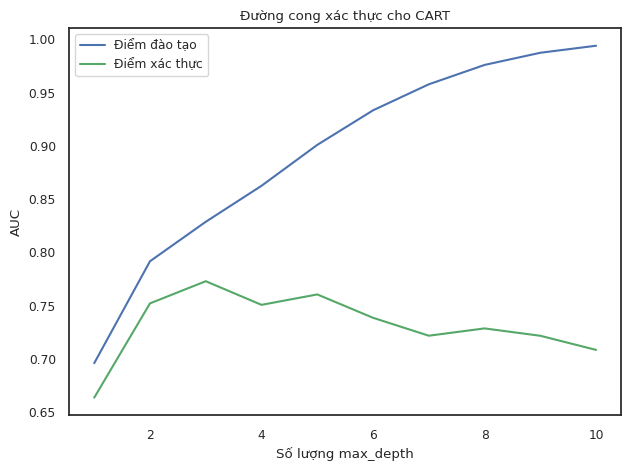

In [ ]:
# Sử dụng đường cong xác nhận để phân tích độ phức tạp của mô hình.
#Trong trường hợp này, chúng tôi thay đổi tham số độ sâu tối đa từ 1 đến 10 và quan sát xem nó ảnh hưởng như thế nào
# điểm ROC AUC cho cả tập huấn luyện và tập kiểm tra.

train_score, test_score = validation_curve(cart_final, X, y,
                                           param_name="max_depth",
                                           param_range=range(1, 11),
                                           scoring="roc_auc",
                                           cv=10)

mean_train_score = np.mean(train_score, axis=1)
mean_test_score = np.mean(test_score, axis=1)

# Vẽ đường cong học tập.
plt.plot(range(1, 11), mean_train_score,
         label="Điểm đào tạo", color='b')
plt.plot(range(1, 11), mean_test_score,
         label="Điểm xác thực", color='g')

plt.title("Đường cong xác thực cho CART")
plt.xlabel("Số lượng max_depth")
plt.ylabel("AUC")
plt.tight_layout()
plt.legend(loc='best')
plt.show()

- Nếu hiệu suất trên tập huấn luyện tăng dần và hội tụ tới một giá trị cố định khi kích thước dữ liệu tăng lên, điều này cho thấy mô hình đang học tốt từ dữ liệu và có khả năng khớp tốt với tập huấn luyện.

- Nếu hiệu suất trên tập kiểm tra tăng dần khi kích thước dữ liệu tăng lên và hội tụ tới một giá trị cố định, điều này cho thấy mô hình đang hoạt động tốt trên dữ liệu mới và không bị quá khớp.

- Nếu khoảng cách giữa hai đường cong nhỏ và hai đường hội tụ về cùng một giá trị, điều này cho thấy mô hình không bị quá khớp hoặc thiếu khớp. Nếu khoảng cách lớn và đường cong kiểm tra không hội tụ, có thể cho thấy mô hình đang bị quá khớp và cần điều chỉnh độ phức tạp.

- Nếu mô hình có hiệu suất tốt trên tập huấn luyện nhưng hiệu suất trên tập kiểm tra không tăng lên khi kích thước tập huấn luyện tăng, có thể cho thấy mô hình đang bị thiếu khớp và cần một mô hình phức tạp hơn hoặc bộ dữ liệu lớn hơn.

# **Trực quan hóa cây quyết định**

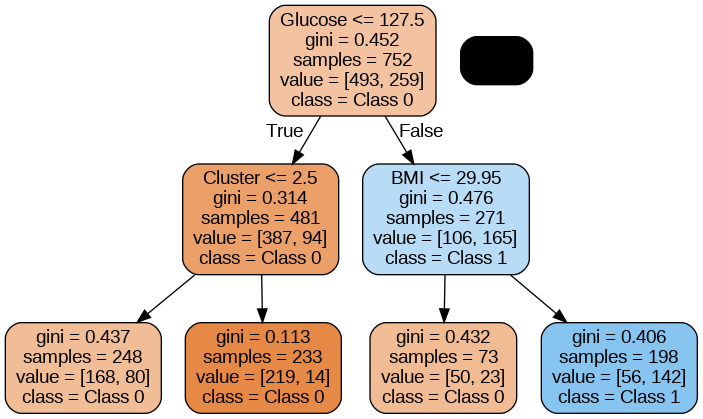

In [ ]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

def visualize_decision_tree(model, feature_names, class_names, file_name):
    dot_data = export_graphviz(model, out_file=None, feature_names=feature_names, class_names=class_names, filled=True, rounded=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    graph.write_png(file_name)
    return Image(graph.create_png())

visualize_decision_tree(cart_final, X.columns, ["Class 0", "Class 1"], "decision_tree.png")

**Quyết định dựa trên Glucose:**

Nếu mức đường huyết (Glucose) của một người thử nghiệm là nhỏ hơn hoặc bằng 127.50, cây quyết định tiếp tục kiểm tra một đặc trưng khác.

Nếu mức đường huyết <= 127.50 và Cluster <= 2.50, mô hình dự đoán là class 0.

Nếu mức đường huyết <= 127.50 và Cluster > 2.50, mô hình cũng dự đoán là class 0.

**Quyết định dựa trên Glucose (phần khác):**

Nếu mức đường huyết > 127.50, cây quyết định kiểm tra một đặc trưng khác, lần lượt là BMI.

Nếu BMI <= 29.95, mô hình dự đoán là class 0.

Nếu BMI > 29.95, mô hình dự đoán là class 1.


Tóm lại, cây quyết định đưa ra dự đoán dựa trên mức đường huyết và sau đó kiểm tra BMI để tạo ra quyết định cuối cùng. Cây này có vẻ đơn giản, và quyết định chủ yếu tập trung vào mức đường huyết và BMI để phân loại các trường hợp thành hai lớp: class 0 và class 1.


In [ ]:
# Chúng ta có thể xem các quy tắc quyết định của mình trên bảng điều khiển
tree_rules = export_text(cart_final, feature_names=list(X.columns))
print(tree_rules)

|--- Glucose <= 127.50
|   |--- Cluster <= 2.50
|   |   |--- class: 0
|   |--- Cluster >  2.50
|   |   |--- class: 0
|--- Glucose >  127.50
|   |--- BMI <= 29.95
|   |   |--- class: 0
|   |--- BMI >  29.95
|   |   |--- class: 1



# DỰ ĐOÁN [TYPE-I & TYPE-II] HOẶC [T1DM & T2DM]

---



# **GIẢI THÍCH VỀ DỰ ĐOÁN**

---
**Chuẩn đoán bệnh tiểu đường và tiền tiểu đường:**


1.   Các xét nghiệm thường được sử dụng để chẩn đoán bệnh tiểu đường và tiền tiểu đường bao gồm xét nghiệm Đường huyết lúc đói (FPG) và xét nghiệm A1C.
2.  Xét nghiệm FPG đo lượng đường trong máu sau 8 giờ nhịn ăn
      - Bình thường: <99 mg/dL
      - Tiền tiểu đường: 100-125 mg/dL
      - Bệnh tiểu đường: >= 126 mg/dL


**Phân biệt loại bệnh tiểu đường bằng mức độ insulin:**

1. Mức nsulin là dấu hiệu của các loại bệnh tiểu đường khác nhau.
2. Mức insulin bình thường: 30-320 μU/mL
3. Bệnh tiểu đường loại 1: Nồng độ insulin thấp hơn (<30 μU/mL) do sự phá hủy các tế bào sản xuất insulin.
4. Bệnh tiểu đường loại 2: Nồng độ insulin cao hơn (>90 μU/mL) so với bình thường.

Mục tiêu: Dự đoán các loại bệnh tiểu đường dựa trên kết quả xét nghiệm máu và nồng độ insulin.


**Mô tả chức năng:**

    - myfunc(x, y):
     - Đầu vào: x (Giá trị insulin), y (Dự đoán loại bệnh tiểu đường)
     - Hợp lý:
        - Nếu x <= 30 và y == 2 (Tiểu đường tuýp 2), trả về y.
        - Nếu x > 30 và y == 2 (Tiểu đường Loại 2), trả về y + 1 (biểu thị một loại khác).
        - Ngược lại, trả về y.

**Quá trình dự đoán:**

1. Chẩn đoán: Sử dụng xét nghiệm FPG và xét nghiệm A1C để chẩn đoán bệnh tiểu đường hoặc tiền tiểu đường dựa trên mức đường huyết.
2. Dự đoán loại: Xác định loại bệnh tiểu đường bằng cách sử dụng nồng độ insulin:
    - Nếu 'Kết quả' == 2 (Bệnh tiểu đường Loại 2):
    - Nếu Insulin > 30, điều chỉnh dự đoán sang loại khác.
    - Nếu 'Kết quả' != 2 (Các loại bệnh tiểu đường khác), giữ nguyên dự đoán ban đầu.



---


1. Trích xuất Glucose, Insulin và Kết quả trong tệp csv mới




In [ ]:
# Tải tập dữ liệu Pima Ấn Độ
file_path = '/content/drive/MyDrive/Data/diabetes.csv'  # Replace with your file path
pima_data = pd.read_csv(file_path)

print(pima_data.columns)

# Chọn các cột cụ thể: 'glucose', 'insulin', 'outcome'
selected_columns = ['Glucose', 'Insulin', 'Outcome']
selected_data = pima_data[selected_columns]

# Lưu dữ liệu đã chọn vào tệp CSV mới
output_file_path = '/content/drive/MyDrive/Data/diabetes_new.csv'  # Thay thế bằng đường dẫn tệp đầu ra mong muốn của bạn
selected_data.to_csv(output_file_path, index=False)

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')




---


2. Đọc và hiển thị dữ liệu mới

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Data/diabetes_new.csv')
data.head()

,Glucose,Insulin,Outcome
0,148,0,1
1,85,0,0
2,183,0,1
3,89,94,0
4,137,168,1




---


# **Mô tả dữ liệu**

In [ ]:
data.describe()

,Glucose,Insulin,Outcome
count,768.000000,768.000000,768.000000
mean,120.894531,79.799479,0.348958
std,31.972618,115.244002,0.476951
min,0.000000,0.000000,0.000000
25%,99.000000,0.000000,0.000000
50%,117.000000,30.500000,0.000000
75%,140.250000,127.250000,1.000000
max,199.000000,846.000000,1.000000


---

# **Huấn luyện và phân chia dữ liệu**





In [ ]:
from sklearn.model_selection import train_test_split
splitRatio = 0.2

train , test = train_test_split(data,test_size = splitRatio,random_state = 123)

X_train = train[[x for x in train.columns if x not in ["Outcome"]]]
y_train = train[["Outcome"]]

X_test  = test[[x for x in test.columns if x not in ["Outcome"]]]
y_test  = test[["Outcome"]]



---


# **Hiển thị hình dạng của dữ liệu được chia tách**

In [ ]:
from sklearn.model_selection import train_test_split
#X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(614, 2)
(614, 1)
(154, 2)
(154, 1)




---


# **Sử dụng K-Neighbour**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier()

knn.fit(X_train,y_train)
prediction = knn.predict(X_test)
accuracy_score(y_test,prediction)

0.7402597402597403



---


# **Lấy dữ liệu tùy chỉnh để kiểm tra dự đoán của chúng tôi**

In [ ]:
new_df = pd.DataFrame([[160, 30]])
new_df.columns = ["Glucose", "Insulin"]
prediction = knn.predict(new_df)

if prediction == 1:
    print('Type-2')
else:
    print('Type-1')

Type-2




---


# **Lưu và hiển thị tất cả các dự đoán của T1DM và T2DM**

In [ ]:
# Đưa ra dự đoán cho toàn bộ tập dữ liệu bằng trình phân loại KNN
predictions = knn.predict(data[['Glucose', 'Insulin']])

# Ánh xạ dự đoán để nhập nhãn ('Loại 1' hoặc 'Loại 2')
prediction_labels = np.where(predictions == 1, 'Type-2', 'Type-1')

# Thêm nhãn được dự đoán vào DataFrame
data['Prediction'] = prediction_labels

# Hiển thị DataFrame với các dự đoán
print(data)

# Lưu DataFrame với các dự đoán vào tệp Excel
data.to_excel('/content/drive/MyDrive/Data/diabetes.xlsx', index=False)

     Glucose  Insulin  Outcome Prediction
0        148        0        1     Type-1
1         85        0        0     Type-1
2        183        0        1     Type-2
3         89       94        0     Type-1
4        137      168        1     Type-2
..       ...      ...      ...        ...
763      101      180        0     Type-1
764      122        0        0     Type-1
765      121      112        0     Type-1
766      126        0        1     Type-1
767       93        0        0     Type-1

[768 rows x 4 columns]




---


# **Đã lưu mô hình**

In [ ]:
import pickle

# Giả sử 'knn' là trình phân loại KNN đã được huấn luyện của bạn
# Lưu mô hình KNN đã huấn luyện vào một tệp bằng cách sử dụng pickle
with open('/content/drive/MyDrive/Data/diabetes.png', 'wb') as file:
    pickle.dump(knn, file)